# Procesamiento de Lenguaje Natural

El objetivo de este proyecto será desarrollar un modelo de ML para predecir el puntaje asignado a un ítem de Amazon a partir de la crítica que hace un/a usuario/a.

El mismo se organiza en tres partes:

   * PARTE A: Exploración y Transformación de datos
   * PARTE B: Modelos de Machine Learning 
   * PARTE C: Investigación/Interpretación de los datos
   
Disponibilizo a continuación el link al repositorio de Github:  
https://github.com/JuanOrtolani/NLP-Sentiment-Analysis-of-Amazon-Reviews/tree/master
   
## PARTE A: Exploración y Transformación de datos

Comenzaremos con una breve exploración del dataset para conocer un poco acerca del conjunto de datos con el se trabajará. 

Luego realizaremos un preprocesamiento de datos/ingeniería de atributos. Aquí aplicaremos Tokenización, técnicas para reducir unidades semánticas a su raíz y por último técnicas de vectorización para poder llevar los datos a un modelo de ML.

### Exploración
A) Carga de datos y librerías

Comenzamos cargando las librerías y dataset a utilizar. Es imporarte tener en cuenta que la librería NLTK debe configurarse.

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
import nltk
import re

# Esto sirve para configurar NLTK. La primera vez puede tardar un poco
# nltk.download('punkt')
# nltk.download('stopwords')

In [2]:
amazon_dataset = pd.read_json('dataset_es_dev.json', lines= True)
amazon_dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


B) Datatypes check para verificar si es necesario realizar conversiones o no

In [3]:
amazon_dataset.dtypes

review_id           object
product_id          object
reviewer_id         object
stars                int64
review_body         object
review_title        object
language            object
product_category    object
dtype: object

Es importante también analizar si el dataset contiene más de un idioma o no para determinar la manera de trabajarlo

In [4]:
amazon_dataset['language'].value_counts()

es    5000
Name: language, dtype: int64

A simple vista, no pareciera necesário hacer conversiones. El dataset sólo contiene datos en español y los tipos de datos de todas las columnas están OK

C) Check filas duplicadas

In [5]:
filas_duplicadas = amazon_dataset[amazon_dataset.duplicated()]
print('Cantidad de filas duplicadas:', filas_duplicadas.shape[0])

Cantidad de filas duplicadas: 0


No hay filas duplicadas que eliminar

D) Tamaño del dataset, rango de calificación, cantidad de instancias por rango y categoría.

In [6]:
print('Filas -->', amazon_dataset.shape[0],'\nColumnas -->', amazon_dataset.shape[1])

Filas --> 5000 
Columnas --> 8


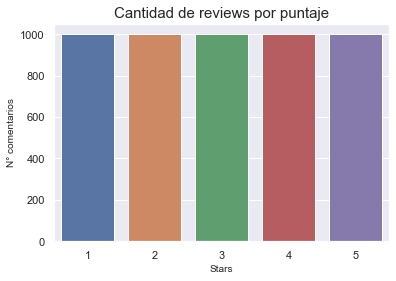

3    1000
2    1000
5    1000
1    1000
4    1000
Name: stars, dtype: int64

In [7]:
sns.countplot(amazon_dataset.stars)
plt.title('Cantidad de reviews por puntaje', fontsize=15)
plt.ylabel('N° comentarios', fontsize=10)
plt.xlabel('Stars', fontsize=10)
plt.show()
amazon_dataset['stars'].value_counts()

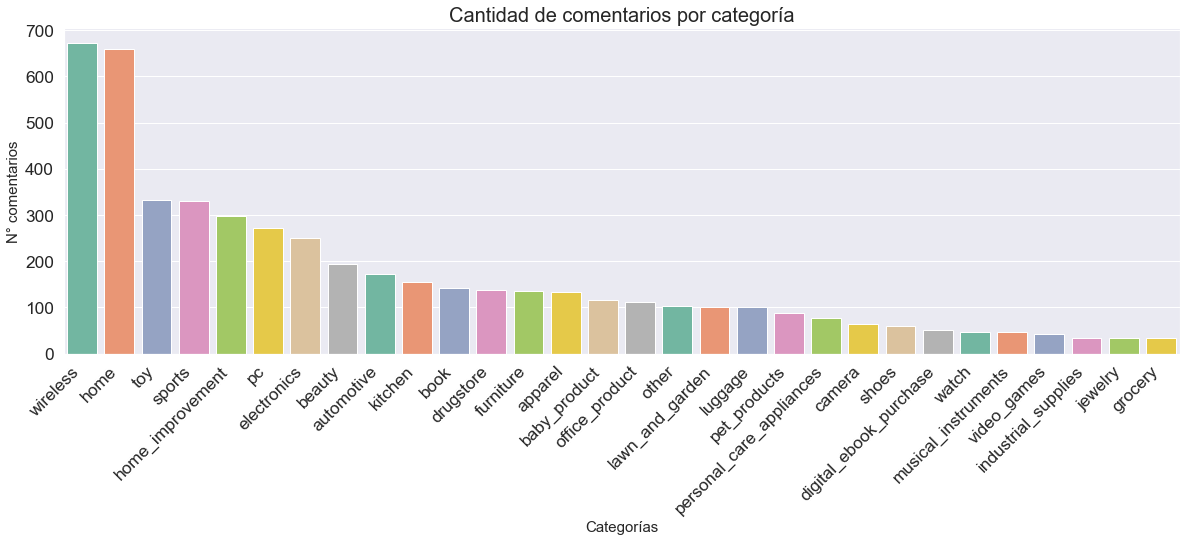

wireless                    672
home                        659
toy                         332
sports                      331
home_improvement            299
pc                          273
electronics                 251
beauty                      195
automotive                  173
kitchen                     156
book                        142
drugstore                   137
furniture                   135
apparel                     133
baby_product                117
office_product              112
other                       103
lawn_and_garden             101
luggage                     101
pet_products                 89
personal_care_appliances     77
camera                       64
shoes                        60
digital_ebook_purchase       51
watch                        47
musical_instruments          46
video_games                  43
industrial_supplies          34
jewelry                      34
grocery                      33
Name: product_category, dtype: int64

In [8]:
plt.figure(figsize = (20,6))
sns.countplot(data = amazon_dataset, x = 'product_category', order = amazon_dataset['product_category'].value_counts().index,palette='Set2')
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light', fontsize='x-large')
plt.yticks(rotation=0, horizontalalignment='right',fontweight='light', fontsize='x-large')
plt.title('Cantidad de comentarios por categoría', fontsize=20)
plt.ylabel('N° comentarios', fontsize=15)
plt.xlabel('Categorías', fontsize=15)
plt.show()
amazon_dataset['product_category'].value_counts()

### Transformación / Preprocesamiento

Ya es una tarea compleja el análisis e interpretación de sentimientos para los humanos, indudablemente también lo sea para las computadoras. Para ayudarlas en esa tarea es necesario extraer características de cada texto que nos sirvan para ir apuntando al objetivo. 

Desarrollaremos en las siguientes celdas una serie de pasos a través de los cuales iremos preparando los datos para poder volcarlos a modelos de ML que nos ayuden con nuestro objetivo.

#### Normalización

##### 1. Regex

Las expresiones regulares (regular expressions) o regex son una herramienta incluida en muchos lenguajes de programación que nos permite buscar texto a través de ciertas reglas definidas.
En Python, la librería para hacer esto se llama `re`.

En este caso, vamos a utilizar dicha librería para reemplazar los caracteres que no sean letras por espacios.

Al principio, aplicaremos estos pasos solamente a una review al azar para entender como funcionan y luego lo aplicaremos sobre todo el dataset.

--> Random Review

In [9]:
random_review = amazon_dataset.iloc[4292,:].review_body
print(random_review)

Esta muy bien acabado, muy prácticos los bolsillos y con la cremallera se ajusta muy bien. Da muy buena presencia, no es el típico descartable.


In [10]:
regex_review=re.sub("[^a-zA-Z]"," ",str(random_review))
regex_review

'Esta muy bien acabado  muy pr cticos los bolsillos y con la cremallera se ajusta muy bien  Da muy buena presencia  no es el t pico descartable '

Como podemos observar, la función que acabamos de aplicar no considera letras como tal a aquellos caracteres que incluyan tildes, diéresis o virgulillas. Todos ellos son frecuentemente utilizados en el idioma español asi que deberemos ajustar la técnica.

Para ello, trabajaremos en `unicode`. Aquí, cada grafema (caracter) se descompone en su equivalencia de caracter base seguido de sus marcas como podemos ver en la imágen.

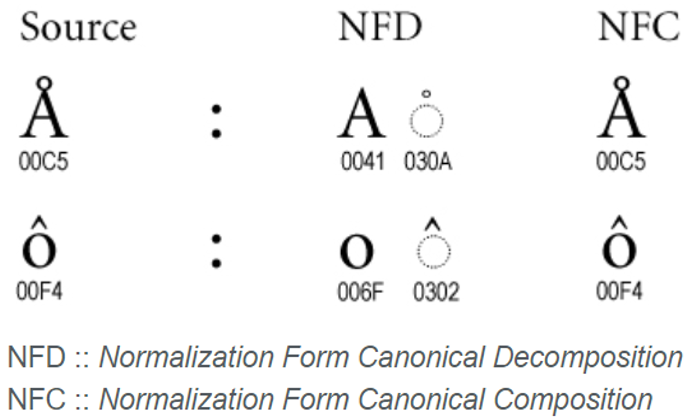

 
En la forma NFD, los diacríticos son puntos de código separados de su caracter base. Esto nos permite separar y eliminar lo que no queremos.

En este caso eliminaremos todas las marcas diacríticas excepto la `ñ`. Para ello, definiremos un regex donde el primer grupo es el caracter base y los diacríticos están fuera del grupo.  
Todas las marcas diacríticas están en un bloque en el rango `U+0300` - `U+036F` (Combining Diacritical Marks). Y vamos a hacer la excepción para `U+0303`, la virgulilla (~), pero sólo si está después de una n (reemplazando otras como una ã)
y sólo si no tiene otros diacríticos (reemplazando cosas raras como ñ͚͡). Con esto llegamos a la expresión:

   `([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+` donde:
    
* `([^n\u0300-\u036f])[\u0300-\u036f]+` -- > un caracter que no es una n ni un diacrítico, seguido de diacríticos.

* `(n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+` -- > una n que no está seguida por ~ (a menos que esta última esté seguida por otro diacrítico), entonces sí que coincida con todos los diacríticos que le siguen.

Luego, reemplazando por `\1` nos quedamos con la letra sin el diacrítico.  
Finalmente, una vez realizado la sustitución volveremos a la forma compuesta y convertiremos todo el texto a minúscula.

In [11]:
import re
from unicodedata import normalize

regex_review = random_review


# -> NFD y eliminar diacríticos
regex_review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", regex_review), 0, re.I)
regex_review = re.sub("[^a-zA-Z]"," ",str(regex_review))


# -> NFC
regex_review = normalize( 'NFC', regex_review)

# -> Minúscula
regex_review = regex_review.lower()

print( regex_review )

esta muy bien acabado  muy practicos los bolsillos y con la cremallera se ajusta muy bien  da muy buena presencia  no es el tipico descartable 


#### Tokenización

Tokenizar hace referencia a separar textos por unidad semántica, ésto nos permite analizar cada unidad por separado.

Para ello utilizaremos la librería NLTK (Natural Language Tokenizer) especializada en tokenizar textos. 

1. Comenzamos con `sent_tokenize` que dividirá nuestro texto en oraciones

In [12]:
random_review_st = nltk.tokenize.sent_tokenize(random_review)
random_review_st

['Esta muy bien acabado, muy prácticos los bolsillos y con la cremallera se ajusta muy bien.',
 'Da muy buena presencia, no es el típico descartable.']

2.Contiuamos con `word_tokenize` que opera a nivel palabra

In [13]:
regex_review_wt = nltk.tokenize.word_tokenize(regex_review)
regex_review_wt

['esta',
 'muy',
 'bien',
 'acabado',
 'muy',
 'practicos',
 'los',
 'bolsillos',
 'y',
 'con',
 'la',
 'cremallera',
 'se',
 'ajusta',
 'muy',
 'bien',
 'da',
 'muy',
 'buena',
 'presencia',
 'no',
 'es',
 'el',
 'tipico',
 'descartable']

#### 2. Información de contexto

Entrando en detalle, podemos notar que no todas las palabras en el texto poseen la misma importancia, algunas transimten mas información, digamos que tienen mayor carga semántica y otras no tanto.

En NLP, muchas veces vamos a querer deshacernos de los tokens de menor carga semántica para trabajar solamente con aquellos de mayor carga. A aquellos tokens descartados se los conoce como "stop words". Para no tener que hacer el trabajo de identificar y filtrar a mano cada una de las stop words, nltk nos ofrece un catálogo predefinido de *stop words* que podemos modificar a gusto según lo necesitemos.

##### A. Stopwords

Importamos los `stopwords` que ya tiene preestablecidos NLTK para el español

In [14]:
stop_words = set(nltk.corpus.stopwords.words('spanish'))
stop_words

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

Caso consideremos necesários, es posible agregar palabras a la lista original de *stopwords*

Quitamos de la review elegida los stopwords y enlistamos las palabras eliminadas

In [15]:
regex_review_wt_sin_sw = [word for word in regex_review_wt if word not in stop_words]
regex_review_wt_sin_sw

['bien',
 'acabado',
 'practicos',
 'bolsillos',
 'cremallera',
 'ajusta',
 'bien',
 'da',
 'buena',
 'presencia',
 'tipico',
 'descartable']

In [16]:
filtered_words = []
for w in regex_review_wt:
    if w in stop_words: filtered_words.append(w)
filtered_words

['esta',
 'muy',
 'muy',
 'los',
 'y',
 'con',
 'la',
 'se',
 'muy',
 'muy',
 'no',
 'es',
 'el']

**Frecuencia de palabras**

Una vez ya tokenizada la review por palabras y sin stopwords, usamos `nltk` para extrar la frecuencia con que aparece cada palabras

In [17]:
freq = nltk.FreqDist(regex_review_wt_sin_sw)
freq

FreqDist({'bien': 2, 'acabado': 1, 'practicos': 1, 'bolsillos': 1, 'cremallera': 1, 'ajusta': 1, 'da': 1, 'buena': 1, 'presencia': 1, 'tipico': 1, ...})

#### 3. Stemming
Por razones gramaticales muchas palabras pueden escribirse de manera distinta (debido a conjugación, género, número) pero tener el mismo significado para el texto. Por ejemplo si decimos "jugar", "jugando" o "juega", debido a como estan conjugadas, la computadora puede tratarlas como palabras distintas. Pero, en términos de significado, todas estan relacionadas al verbo Jugar. Muchas veces nos va a convenir unir todas estos términos en uno solo.

Una de las manera de hacer esto es por "STEMMING". El Stemming es un proceso eurístico que recorta la terminación de las palabras, agrupándolas por su raiz. 

Aplicamos dicho proceso a la review que venimos tomando como ejemplo para ver como funciona:

In [18]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
random_review_stemming=[stemmer.stem(palabra) for palabra in regex_review_wt_sin_sw]
random_review_stemming

['bien',
 'acabado',
 'practico',
 'bolsillo',
 'cremallera',
 'ajusta',
 'bien',
 'da',
 'buena',
 'presencia',
 'tipico',
 'descart']

### Dataset Completo

Ahora que ya recorrimos los pasos de la normalización con un review de ejemplo, aplicaremos la misma secuencia para el dataset entero.

a. Importamos nuevamente el dataset completo

In [19]:
amazon_dataset = pd.read_json('dataset_es_dev.json', lines= True)
amazon_dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


b. Tomamos solo las columnas de interes

In [20]:
amazon_dataset = pd.concat([amazon_dataset.review_body,amazon_dataset.stars],axis=1)
amazon_dataset.head()

,review_body,stars
0,"Malisimo, muy grande demasiado aparatoso y mal...",1
1,No he recibido el pedido no la devolución,1
2,"Tengo que buscar otro sistema, este no funcion...",1
3,Utilicé las brocas de menor diámetro y se me d...,1
4,No me gusta su olor a viejo y aspecto malo,1


c. Antes de realizar el proceso de Stemming, vamos a normalizar el texto de la manera que ya estuvimos viendo. 

In [21]:
# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('spanish')

In [22]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
review_list=[]
for review in range(amazon_dataset.shape[0]):
    review = amazon_dataset.iloc[review].review_body
    # -> NFD y eliminar diacríticos
    review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", review), 0, re.I)
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review = re.sub("[^a-zA-Z]"," ",str(review))
    # -> NFC
    review = normalize( 'NFC', review)
    # -> Minúscula
    review = review.lower()
    # Tokenizamos para separar las palabras del titular
    review = nltk.tokenize.word_tokenize(review)
    # Sacamos las Stopwords
    review = [word for word in review if word not in stop_words]
         
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[stemmer.stem(palabra) for palabra in  review]
    # Por ultimo volvemos a unir el titular
    review=" ".join(review)
    
    # Vamos armando una lista con todos los titulares
    review_list.append(review)

d. Agregamos al dataset una columna llamado `review_stemming` que contenga los titulares stemmizados

In [23]:
amazon_dataset["review_stemming"] = review_list
amazon_dataset.tail()

,review_body,stars,review_stemming
4995,Me ha encantado la cesta. Ha llegado impecable...,5,encantado cesta llegado impec taman util pesa ...
4996,Desempeña su función correctamente,5,desempen funcion correctament
4997,Me ha encantado la diadema! Las flores son tal...,5,encantado diadema flore tal vienen imagen veni...
4998,"A mi me gustan mucho las fundas TPU, ya que so...",5,gustan funda tpu funda normalment fina colorid...
4999,El artículo ha cumplido con las expectativas q...,5,articulo cumplido expectativa deseaba


e. Armamos un nuevo dataset llamado `amazon_dataset_stem` que contenga solo las columnas `review_stem` y `stars`

In [24]:
amazon_dataset_stem=pd.concat([amazon_dataset.review_stemming,amazon_dataset.stars],axis=1)
amazon_dataset_stem.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
amazon_dataset_stem.head()

,review_stemming,stars
0,malisimo grand demasiado aparatoso mal protect...,1
1,recibido pedido devolucion,1
2,buscar sistema funciona bien abrazadera lleva ...,1
3,utilic broca menor diametro doblaron varia si ...,1
4,gusta olor viejo aspecto malo,1


## PARTE B: Modelos de Machine Learning 

#### Vectorización

Hasta ahora, tenemos un grupo de palabras por cada titular (bag of words). 

La idea ahora es representar esta lista de palabras como un vector para que podamos alimentar modelos de ML.  

Para esto vamos a utilizar la función `CountVectorizer` de Scikit-Learn. Esta función nos permite representar cada título por un vector con un 1 en las palabras que contiene y un 0 en las que no. Además, vamos a trabajar únicamente con las palabras que aparecen más veces en el texto, ya que las que aparecen una única vez o pocas veces no nos van a brindar información que se pueda generalizar.

a. Tomamos la lista de palabras y el vector que nos dice la cantidad de stars del artículo

In [25]:
# Tomamos la lista de palabras y el vector que nos dice la cantidad de stars

stem_list_review = list(amazon_dataset_stem['review_stemming'].values)
stem_stars = amazon_dataset_stem['stars'].values

b. Preparamos el conversor de bag of words a vectores que traemos de sklearn utilizando `CountVectorizer`

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000
ngram_range=(1, 2)

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features, ngram_range=ngram_range)

c. Ahora sí, generamos los vectores para cada título a partir del corpus total.

In [27]:
stem_couvec_matriz_review = cou_vec.fit_transform(stem_list_review)

# Tomamos las palabras
stem_couvec_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",stem_couvec_words[0:50])

50 palabras mas usadas:  ['abajo', 'abierta', 'abierto', 'abr', 'abrir', 'acaba', 'acabado', 'acabo', 'accesorio', 'aceit', 'acept', 'aconsejo', 'adapta', 'adapta bien', 'adaptador', 'adecuado', 'adema', 'adhesivo', 'ado', 'agrad', 'agua', 'aguanta', 'agujero', 'ahi', 'ahora', 'air', 'ajust', 'ajusta', 'ajusta bien', 'alguien', 'algun', 'alguna', 'almohada', 'alta', 'altavoz', 'alto', 'altura', 'amazon', 'an', 'ancho', 'antena', 'anterior', 'apaga', 'aparato', 'aparec', 'apart', 'apena', 'aplicacion', 'app', 'aqui']


#### Modelado

Ahora sí estamos listos para comenzar con nuestros modelos de ML.  
La métrica que utilizaré para comparar los modelos es accuracy. La misma nos indica, de todas las clases, cuánto predijimos correctamente. Debería ser lo más alto posible.

a. Primero, como siempre, separamos en test y train.

In [28]:
X_stem_couvec = stem_couvec_matriz_review.toarray()
y_stem_couvec = stem_stars

from sklearn.model_selection import train_test_split
Xtrain_stemcouvec, Xtest_stemcouvec, ytrain_stemcouvec, ytest_stemcouvec = train_test_split(X_stem_couvec,y_stem_couvec,test_size=0.2,random_state=42,stratify=y_stem_couvec)

Tambien definimos una función que nos permite plotear los resultados en una matriz de confusión.

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    rates=["1","2","3","4","5"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(rates)
    ax.set_yticklabels(rates)
    plt.show()

    return

#### Random Forest
a. Empecemos por un Random Forest para tener un benchmark de referencia.

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_stemcouvec = RandomForestClassifier(n_estimators=10, n_jobs=-1, oob_score = True, random_state = 42)
rf_stemcouvec.fit(Xtrain_stemcouvec,ytrain_stemcouvec)
print("acc: ",rf_stemcouvec.score(Xtest_stemcouvec,ytest_stemcouvec))

acc:  0.351


b. Graficamos su matriz de confusión:

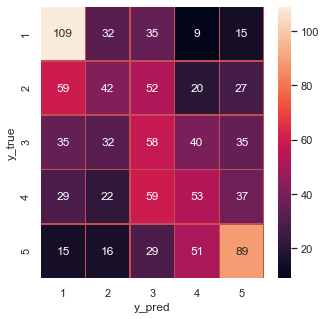

In [31]:
y_pred_stemcouvec=rf_stemcouvec.predict(Xtest_stemcouvec)
confusion(ytest_stemcouvec,y_pred_stemcouvec)

c. Un punto destacable de Random Forest es poder ver la importancia de los features que utilizó para clasificar. Veamos en este caso cuales son las palabras que mayormente determinan el puntaje de un artículo para este clasificador.

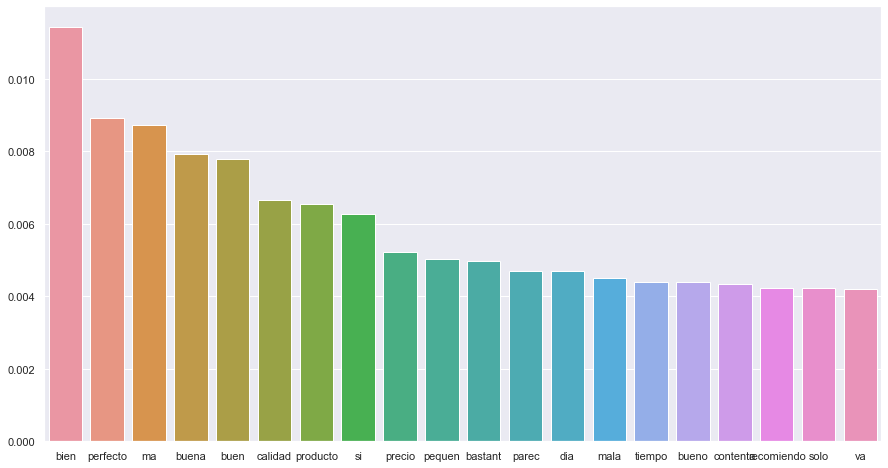

In [32]:
# Le preguntamos la importancia de cada feature (cada palabra)
rf_stemcouvec_importances = rf_stemcouvec.feature_importances_
# Tomamos la lista de palabras
stemcouvec_words = cou_vec.get_feature_names()
columns = stemcouvec_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices_stemcouvec = np.argsort(rf_stemcouvec_importances)[::-1]
indices_stemcouvec = indices_stemcouvec[:20]
selected_columns = [columns[i] for i in indices_stemcouvec]
selected_importances = rf_stemcouvec_importances[indices_stemcouvec]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

#### XGBoost
Continuamos ahora con un XGBoost

In [33]:
import xgboost as xgb

xgbc_stemcouvec = xgb.XGBClassifier(n_estimators= 10, max_depth= 1, learning_rate= 0.1, gamma= 0.2, colsample_bytree= 0.2)
xgbc_stemcouvec.fit(Xtrain_stemcouvec,ytrain_stemcouvec)
xgbc_stemcouvec.score(Xtrain_stemcouvec,ytrain_stemcouvec)  

0.342

b. Graficamos su matrz de confusión:

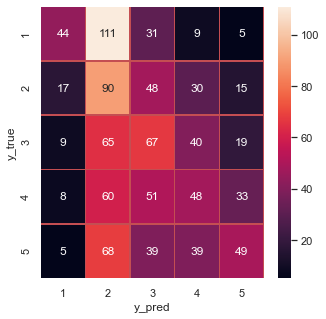

In [34]:
y_pred_stemcouvec=xgbc_stemcouvec.predict(Xtest_stemcouvec)
confusion(ytest_stemcouvec,y_pred_stemcouvec)

#### SVM
Por último vamos a utilizar uno de los modelos mas prometedores para este tipo de datos donde el numero de features es comparable al número de instancias: SVM.

a. Entrenamos un modelo de SVM.

In [35]:
from sklearn.svm import SVC

svc_stemcouvec = SVC(kernel='linear',C = 8)
svc_stemcouvec.fit(Xtrain_stemcouvec,ytrain_stemcouvec)
svc_stemcouvec.score(Xtest_stemcouvec,ytest_stemcouvec)

0.362

b. Graficamos su matrz de confusión:

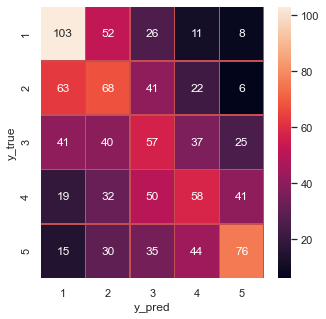

In [36]:
y_pred_stemcouvec=svc_stemcouvec.predict(Xtest_stemcouvec)
confusion(ytest_stemcouvec,y_pred_stemcouvec)

El mejor modelo según la métrica seleccionada es SVM.  
Será ahora nuestro nuevo modelo de referencia y elaboraremos una optimización de hiperparámetros para ver si podemos llegar a una mejor versión.

Para el análisis de optimización de hiperparámetros utilizaremos el método RandomSearch


In [37]:
from sklearn.model_selection import RandomizedSearchCV

#SVC

svc = SVC()

# Grilla Random SVM
grillarandom = {'kernel':['poly', 'rbf', 'sigmoid'],
                                'C': [5, 10]}

# Random Search
random_svc = RandomizedSearchCV(svc, grillarandom,n_iter=3, random_state=0, cv=5)

# Entrenamos: SVM con la grilla definida arriba y CV con tamaño de Fold=5
random_svc.fit(Xtrain_stemcouvec,ytrain_stemcouvec)

print("Mejores parametros: "+str(random_svc.best_params_))
print("Mejor Acc: "+str(random_svc.best_score_)+'\n')

scores_random_svc = pd.DataFrame(random_svc.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_svc.head()

Mejores parametros: {'kernel': 'sigmoid', 'C': 5}
Mejor Acc: 0.3805



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.483034,0.457793,2.965347,0.078135,sigmoid,5,"{'kernel': 'sigmoid', 'C': 5}",0.36500,0.38250,0.38875,0.40125,0.3650,0.38050,0.014022,1
1,13.359755,0.456876,2.879418,0.091673,sigmoid,10,"{'kernel': 'sigmoid', 'C': 10}",0.34875,0.36375,0.36000,0.40625,0.3675,0.36925,0.019535,2
2,23.118688,0.811404,3.232281,0.077012,rbf,5,"{'kernel': 'rbf', 'C': 5}",0.35375,0.36625,0.35625,0.38875,0.3675,0.36650,0.012359,3


In [38]:
svc_stemcouvec = SVC(kernel='sigmoid',C = 5)
svc_stemcouvec.fit(Xtrain_stemcouvec,ytrain_stemcouvec)
svc_stemcouvec.score(Xtest_stemcouvec,ytest_stemcouvec)

0.376

## PARTE C: Investigación/Interpretación de los datos

Hemos avanzado bastante en el desarrollo de nuestros modelos pero aún hay posibilidades de mejorar el poder predictivo de los mismos. 

Hasta aquí sólo hemos trabajado con Stemmización y CountVectorizer, pero existen otras maneras de procesar y vectorizar el texto que me gustaría probar ya que podrían aportar mejoras para nuestro proyecto. 

La primer técnica es la de lemmatización como una alternativa al stemming; la segunda, como alternativa de vectorización, es TF-IDF.  
Otra práctica que me gustaría intentar es combinar las técnicas de Random y Grid Search para la optimización de hiperparámetros.

Para incorporar ambas ideas, perimero crearía nuevos datasets que acoplaría a los ya existentes y luego trabajaría en la hiperoptimización de modelos para ver cuales son los mejores hiperparámetros y la mejor combinación de técnicas.

Aplicando dichas incoporaciones tendría un estudio bastante más exhaustivo del problema y esperaría obtener mejores valores de accuracy.

En las celdas a continuación aplicaré una demostración de las ideas que acabo de presentar

#### Lemmatization

Como mencionaoms recién, otra manera de llevar distintas palabras a una raíz común es mediante el procezo de 'Lemmatizar' el texto. Es similar al 'Stemming' pero un poco más educado, ya que intenta realizar el proceso teniendo en cuenta cuál es el rol que la palabra cumple en el texto. Esto quiere decir que su accionar será distinto si la palabra a lemmantizar está actuando como verbo, sustantivo, etc. 

Para usar las funciones que ofrece `nltk` para lemmantizar, tendremos primero que descargar la libreria `Wordnet` que se encuentra en la solapa `corpora` y las librerias `maxent_treebank_pos_` y `averaged_perceptron_tagger` que se encuentra en la solapa `Models`. Para eso es necesário ejecutar la siguiente celda:

In [39]:
# nltk.download()

In [40]:
# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

Al igual que como con Stemming, analizaremos el funcionamiento con una review de ejemplo. Aprovecharemos el preprocesamiento realizado anteriormente utilizando la misma review

In [41]:
regex_review_wt_sin_sw

['bien',
 'acabado',
 'practicos',
 'bolsillos',
 'cremallera',
 'ajusta',
 'bien',
 'da',
 'buena',
 'presencia',
 'tipico',
 'descartable']

Revisando la dicumentación, vemos que se recomienda informar qué rol está cumpliendo la palabra en la oración. Esto se hace pasandole un argumento extra a la función llamado POS (Part Of Speech).

Hay distintos metodos que intentan averiguar el rol que cumple una palabra en una oración. Utilizaré uno que viene incorporado en NLTK llamado pos_tag.

In [42]:
print(nltk.pos_tag(regex_review_wt_sin_sw))

[('bien', 'NN'), ('acabado', 'NN'), ('practicos', 'NN'), ('bolsillos', 'NN'), ('cremallera', 'NN'), ('ajusta', 'NN'), ('bien', 'NN'), ('da', 'NN'), ('buena', 'NN'), ('presencia', 'NN'), ('tipico', 'NN'), ('descartable', 'JJ')]


Las etiquetas refieren al tipo de palabra. Vamos a definir una función para traducir estas etiquetas a los valores de POS que entiende `wordnet_lemmatizer`.

In [43]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

Finalmente como funciona en nuestro ejemplo.

In [44]:
review_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in regex_review_wt_sin_sw]
tipo_palabra = [get_wordnet_pos(w) for w in regex_review_wt_sin_sw]

# Veamos como cambiaron las palabras
print("{0:20}{1:20}{2:20}".format("Palabra:","Tipo:","Lemma:"))
for i in range(len(regex_review_wt_sin_sw)):
    print ("{0:20}{1:20}{2:20}".format(regex_review_wt_sin_sw[i],tipo_palabra[i],review_lemma[i]))

Palabra:            Tipo:               Lemma:              
bien                n                   bien                
acabado             n                   acabado             
practicos           n                   practicos           
bolsillos           n                   bolsillos           
cremallera          n                   cremallera          
ajusta              n                   ajusta              
bien                n                   bien                
da                  n                   da                  
buena               n                   buena               
presencia           n                   presencia           
tipico              n                   tipico              
descartable         a                   descartable         


Aquí podemos notar que no corta descartable, ya que lo considera un adjetivo.

Ahora aplicaremos todo esto al dataset haciendo un procedimiento análogo al que hicimos para la parte de Stemming.

In [45]:
# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
amazon_dataset = pd.read_json('dataset_es_dev.json', lines= True)
amazon_dataset = pd.concat([amazon_dataset.review_body,amazon_dataset.stars],axis=1)
amazon_dataset.head()

,review_body,stars
0,"Malisimo, muy grande demasiado aparatoso y mal...",1
1,No he recibido el pedido no la devolución,1
2,"Tengo que buscar otro sistema, este no funcion...",1
3,Utilicé las brocas de menor diámetro y se me d...,1
4,No me gusta su olor a viejo y aspecto malo,1


In [46]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega lemmatizamos cada uno
review_list=[]
for review in range(amazon_dataset.shape[0]):
    review = amazon_dataset.iloc[review].review_body
    # -> NFD y eliminar diacríticos
    review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", review), 0, re.I)
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review = re.sub("[^a-zA-Z]"," ",str(review))
    # -> NFC
    review = normalize( 'NFC', review)
    # -> Minúscula
    review = review.lower()
    # Tokenizamos para separar las palabras del titular
    review = nltk.tokenize.word_tokenize(review)
             
    # Hasta acá Normalizamos, ahora a lemmatizar
    review = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in review]
    # Sacamos las Stopwords
    review = [word for word in review if word not in stop_words]
    
   # Por ultimo volvemos a unir la review
    review=" ".join(review)
    
    # Vamos armando una lista con todos los titulares
    review_list.append(review)

In [47]:
amazon_dataset["review_lemm"] = review_list
amazon_dataset.tail()

,review_body,stars,review_lemm
4995,Me ha encantado la cesta. Ha llegado impecable...,5,encantado cesta llegado impecable taman util p...
4996,Desempeña su función correctamente,5,desempen funcion correctamente
4997,Me ha encantado la diadema! Las flores son tal...,5,encantado diadema flores tal vienen imagen ven...
4998,"A mi me gustan mucho las fundas TPU, ya que so...",5,gustan fundas tpu fundas normalmente finas col...
4999,El artículo ha cumplido con las expectativas q...,5,articulo cumplido expectativas deseaba


Armamos un nuevo datasate llamado `dataset_lem` que tenga solo las columnas `titular_lemm` y `stars`.

In [48]:
amazon_dataset_lemm = pd.concat([amazon_dataset.review_lemm,amazon_dataset.stars],axis=1)
amazon_dataset_lemm.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
amazon_dataset_lemm.head()

,review_lemm,stars
0,malisimo grande demasiado aparatoso mal protec...,1
1,recibido pedido devolucion,1
2,buscar sistema funciona bien abrazadera lleva ...,1
3,utilice broca menor diametro doblaron varias s...,1
4,gusta olor viejo aspecto malo,1


#### TF-IDF

TF-IDF significa _"Term Frequency-Inverse Document Frequency"_  

Term Frequency significa: cuántas veces un término aparece en un documento. La importancia de esto es que se supone que mientras más veces aparece, más importante es ese término en ese documento.

Sin Embargo, hay términos (como los artículos "la", "el", o las preposiciones "a", "por") que tienen alta frecuencia en todos los textos. Si les asignamos un puntaje alto, no ganaremos información con respecto a cuál es el tópico del documento.  
Aquí participa la segunda parte de la palabra, IDF: Inverse Document Frequency. Esto significa que se compara la frecuencia de la palabra en ese documento con la frecuencia en todo el corpus de documentos. A mayor frecuencia de la palabra en todos los documentos, menor puntaje tendrá. Así evitamos puntuar alto a stop words o palabras que no agregan información sobre ese documento específico.

Al igual que con Stemming, aprovecharemos lo realizado anteriormente para TF-IDF

a. Tomamos la lista de palabras y el vector que nos dice la cantidad de stars del artículo

In [49]:
# Tomamos la lista de palabras y el vector que nos dice la cantidad de stars

lemm_list_review = list(amazon_dataset_lemm['review_lemm'].values)
lemm_stars = amazon_dataset_stem['stars'].values

b. Importamos los módulos de TF-IDF y generamos vectores

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=max_features, ngram_range = ngram_range)

lemm_tfidf_matriz_review = tfidf.fit_transform(lemm_list_review)

# Tomamos las palabras
lemm_tfidf_words = tfidf.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",lemm_tfidf_words[0:50])

50 palabras mas usadas:  ['abajo', 'abierta', 'abierto', 'abre', 'abrir', 'acaba', 'acabado', 'acabados', 'acabo', 'accesorios', 'aceite', 'aceptable', 'aconsejo', 'adapta', 'adapta bien', 'adaptador', 'adecuado', 'ademas', 'ado', 'agradable', 'agua', 'aguanta', 'agujero', 'agujeros', 'ahi', 'ahora', 'aire', 'ajusta', 'ajusta bien', 'alguien', 'algun', 'alguna', 'alta', 'altavoz', 'alto', 'altura', 'amazon', 'an', 'ancho', 'antena', 'anterior', 'apaga', 'aparato', 'aparece', 'aparte', 'apenas', 'app', 'aqui', 'aran', 'armario']


Recapitulando, hemos visto dos técnicas para llevar cada token a su raíz y dos técnicas de vectorización. La idea ahora es generar una dataset por cada combinación de técnicas y evaluar cual es la mejor opción.

Lo primero que haremos entonces es crear la combinación de técnicas:

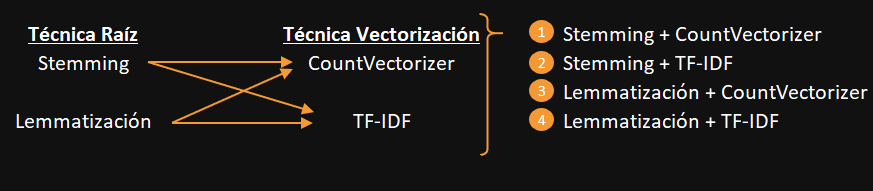

De todas las combinaciones posibles ya hemos definido la 1 y la 4. Vamos ahora a definir la 2 y la 3.

##### 2 -> Stemming + TF-IDF

In [51]:
stem_tfidf_matriz_review = tfidf.fit_transform(stem_list_review)

# Tomamos las palabras
stem_tfidf_words = tfidf.get_feature_names()

##### 3 -> Lemmatización + CountVectorizer

In [52]:
lemm_couvec_matriz_review = cou_vec.fit_transform(lemm_list_review)

# Tomamos las palabras
lemm_couvec_words = cou_vec.get_feature_names()

Ahora que ya tenemos identificadas las 4 combinaciones vamos a definir los conjuntos Train y Test de cada una para poder llevar a los modelos (los conjuntos para la combinación 1 (Stemming + CountVectorizer) ya fueron definidos anteriormente).

-> Conjunto combinación 2: Stemming + TF-IDF

In [53]:
X_stem_tfidf = stem_tfidf_matriz_review.toarray()
y_stem_tfidf = stem_stars

from sklearn.model_selection import train_test_split
Xtrain_stem_tfidf, Xtest_stem_tfidf, ytrain_stem_tfidf, ytest_stem_tfidf = train_test_split(X_stem_tfidf,y_stem_tfidf,test_size=0.2,random_state=42,stratify=y_stem_tfidf)

-> Conjunto combinación 3: Lemmatización + CountVectorizer

In [54]:
X_lemm_couvec = lemm_couvec_matriz_review.toarray()
y_lemm_couvec = lemm_stars

from sklearn.model_selection import train_test_split
Xtrain_lemm_couvec, Xtest_lemm_couvec, ytrain_lemm_couvec, ytest_lemm_couvec = train_test_split(X_lemm_couvec,y_lemm_couvec,test_size=0.2,random_state=42,stratify=y_lemm_couvec)

-> Conjunto combinación 4: Lemmatización + TF-IDF

In [55]:
X_lemm_tfidf = lemm_tfidf_matriz_review.toarray()
y_lemm_tfidf = lemm_stars

from sklearn.model_selection import train_test_split
Xtrain_lemm_tfidf, Xtest_lemm_tfidf, ytrain_lemm_tfidf, ytest_lemm_tfidf = train_test_split(X_lemm_tfidf,y_lemm_tfidf,test_size=0.2,random_state=42,stratify=y_lemm_tfidf)

Una vez definidos los conjuntos haremos un análisis de hiperoptimización de cada uno de los modelos definidos anteriormente con cada uno de los conjuntos definidos.

Como indiqué al comienzo de la etapa C, para el análisis de hiperoptimización, me gustaría probar una técnica combinada de RandomSearch y GridSearch.

La idea con esto es comenzar acotando el espacio de hiperparámetros y luego estudiar específicamente dicho espacio acotado, evaluando en todo momento que el modelo sea representativo.

Para ello inciamos con el método RandomSearch que nos permitirá obtener una muestra aleatoria, a la cual podemos considerar representativa acerca del espacio de combinaciones de hiperparámetros. 

Una vez obtenida dicha muestra, el segundo paso será concentrar el análisis en el nuevo espacio reducido de hiperparámetros; esto es, el espacio definido entre los dos mejores valores para cada hiperparámetro del modelo. Para analizar dicho "subespacio" utilizaremos el método GridSearch.

Finalmente, para asegurarnos que nuestro modelo sea representativo, evaluaremos el mismo utilizando el método de Validación Cruzada.

#### CONJUNTO N°1 (Stemming + CountVectorizer)

**1. RandomForest**

Primero defino la grilla que utilizaremos para RandomSearch y luego entrenamos e imprimimos parámetros y scores.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit

In [57]:
# Modelo RandomForest
rf_stemcouvec = RandomForestClassifier()

# Grilla Random RandomForest
grillarandom_rf_stemcouvec = {'n_estimators':[10, 30, 50, 70, 90],
                              'n_jobs': [-1, None], 
                              'oob_score' : [True, False]}

# Random Search
random_rf_stemcouvec = RandomizedSearchCV(rf_stemcouvec, grillarandom_rf_stemcouvec,n_iter=3, random_state=0, cv=5)

# Entrenamos: RandomForest con la grilla definida arriba y CV con tamaño de Fold=5
random_rf_stemcouvec.fit(Xtrain_stemcouvec, ytrain_stemcouvec)

print("Mejores parametros: "+str(random_rf_stemcouvec.best_params_))
print("Mejor Acc: "+str(random_rf_stemcouvec.best_score_)+'\n')

scores_random_rf_stemcouvec = pd.DataFrame(random_rf_stemcouvec.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_rf_stemcouvec.head()

Mejores parametros: {'oob_score': True, 'n_jobs': None, 'n_estimators': 90}
Mejor Acc: 0.37900000000000006



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_oob_score,param_n_jobs,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.859482,0.326257,0.056246,0.012492,True,None,90,"{'oob_score': True, 'n_jobs': None, 'n_estimat...",0.36625,0.3925,0.38500,0.36875,0.3825,0.3790,0.009981,1
1,4.598428,0.259250,0.078110,0.009879,False,None,90,"{'oob_score': False, 'n_jobs': None, 'n_estima...",0.36625,0.3675,0.38375,0.37000,0.3800,0.3735,0.007045,2
2,1.053022,0.805094,0.074965,0.134538,False,-1,10,"{'oob_score': False, 'n_jobs': -1, 'n_estimato...",0.33000,0.3275,0.34000,0.34750,0.3575,0.3405,0.011113,3


Ya conocemos las combinaciones que mejor performan, podemos acotar el espacio que vamos a analizar mediante GridSearch.

Para automatizar la entrada de datos a la grilla de GridSearch escribí el siguiente código donde para cada hiperparámetro creamos una arreglo organizado de menor a mayor con el intervalo de valores existente entre el primer y segundo top score. Para el caso de los valores categóricos, simplemente guardamos qué valor tomó el hiperparámetro en cada pueba.

In [58]:
first_n_estimators__rf_stemcouvec = scores_random_rf_stemcouvec.iloc[0,6]
second_n_estimators__rf_stemcouvec = scores_random_rf_stemcouvec.iloc[1,6]
if first_n_estimators__rf_stemcouvec < second_n_estimators__rf_stemcouvec:
    n_estimators__rf_stemcouvec=np.arange(first_n_estimators__rf_stemcouvec,second_n_estimators__rf_stemcouvec+1,1)
elif first_n_estimators__rf_stemcouvec == second_n_estimators__rf_stemcouvec:
    n_estimators__rf_stemcouvec=[first_n_estimators__rf_stemcouvec]
else:
    n_estimators__rf_stemcouvec=np.arange(second_n_estimators__rf_stemcouvec,first_n_estimators__rf_stemcouvec+1,1)
#-----------------------------------------------------------------------------------------------------------------------  
first_n_jobs_rf_stemcouvec = scores_random_rf_stemcouvec.iloc[0,5]
second_n_jobs_rf_stemcouvec = scores_random_rf_stemcouvec.iloc[1,5]

if first_n_jobs_rf_stemcouvec is not None and second_n_jobs_rf_stemcouvec is not None:
    
    if first_n_jobs_rf_stemcouvec < second_n_jobs_rf_stemcouvec:
        n_jobs_rf_stemcouvec = [first_n_jobs_rf_stemcouvec,second_n_jobs_rf_stemcouvec]
       
    elif first_n_jobs_rf_stemcouvec>second_n_jobs_rf_stemcouvec:
        n_jobs_rf_stemcouvec = [second_n_jobs_rf_stemcouvec,first_n_jobs_rf_stemcouvec]
        
    elif first_n_jobs_rf_stemcouvec==second_n_jobs_rf_stemcouvec:
        n_jobs_rf_stemcouvec=[first_n_jobs_rf_stemcouvec]
         
elif first_n_jobs_rf_stemcouvec is not None and second_n_jobs_rf_stemcouvec is None:
    n_jobs_rf_stemcouvec=[first_n_jobs_rf_stemcouvec,second_n_jobs_rf_stemcouvec]
    
elif first_n_jobs_rf_stemcouvec is None and second_n_jobs_rf_stemcouvec is not None:
    n_jobs_rf_stemcouvec=[second_n_jobs_rf_stemcouvec,first_n_jobs_rf_stemcouvec]
    
elif first_n_jobs_rf_stemcouvec is None and second_n_jobs_rf_stemcouvec is None:
    if first_n_jobs_rf_stemcouvec==second_n_jobs_rf_stemcouvec:
        n_jobs_rf_stemcouvec=[first_n_jobs_rf_stemcouvec]
        
    else:
        n_jobs_rf_stemcouvec=[first_n_jobs_rf_stemcouvec,second_n_jobs_rf_stemcouvec]
#-----------------------------------------------------------------------------------------------------------------------
first_oob_score_rf_stemcouvec = scores_random_rf_stemcouvec.iloc[0,4]
second_oob_score_rf_stemcouvec = scores_random_rf_stemcouvec.iloc[1,4]
if first_oob_score_rf_stemcouvec == second_oob_score_rf_stemcouvec:
    oob_score_rf_stemcouvec = [first_oob_score_rf_stemcouvec]
else:
    oob_score_rf_stemcouvec = [first_oob_score_rf_stemcouvec,second_oob_score_rf_stemcouvec]

Repito lo mismo con el resto de los modelos

**2. XGBoost**

In [59]:
# Modelo XGBoost
xgbc_stemcouvec = xgb.XGBClassifier()

# Grilla Random XGBoost
grillarandom_xgbc_stemcouvec = {'n_estimators':[50, 100, 150, 200],
                                'max_depth': range (3, 10),
                                'learning_rate': [0.01, 0.1, 0.2, 0.3], 
                                'gamma': [i/10.0 for i in range(3)], 
                                'colsample_bytree' : [i/10.0 for i in range(1, 3)]}

# Random Search
random_xgbc_stemcouvec = RandomizedSearchCV(xgbc_stemcouvec, grillarandom_xgbc_stemcouvec,n_iter=3, random_state=0, cv=5)

# Entrenamos: XGBoost con la grilla definida arriba y CV con tamaño de Fold=5
random_xgbc_stemcouvec.fit(Xtrain_stemcouvec,ytrain_stemcouvec)

print("Mejores parametros: "+str(random_xgbc_stemcouvec.best_params_))
print("Mejor Acc: "+str(random_xgbc_stemcouvec.best_score_)+'\n')

scores_random_xgbc_stemcouvec = pd.DataFrame(random_xgbc_stemcouvec.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_xgbc_stemcouvec.head()

Mejores parametros: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.1}
Mejor Acc: 0.4085



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.467204,0.155981,0.031242,7.747687e-07,50,9,0.2,0.1,0.1,"{'n_estimators': 50, 'max_depth': 9, 'learning...",0.40125,0.40500,0.4225,0.40875,0.4050,0.40850,0.007391,1
1,52.343556,39.801053,0.068735,1.249807e-02,200,9,0.3,0.1,0.2,"{'n_estimators': 200, 'max_depth': 9, 'learnin...",0.38500,0.40125,0.4150,0.42500,0.3975,0.40475,0.013928,2
2,8.346642,0.807950,0.040091,7.287775e-03,100,6,0.2,0.2,0.2,"{'n_estimators': 100, 'max_depth': 6, 'learnin...",0.38500,0.41250,0.4025,0.42250,0.3950,0.40350,0.013096,3


In [60]:
first_n_estimators_xgbc_stemcouvec = scores_random_xgbc_stemcouvec.iloc[0,4]
second_n_estimators_xgbc_stemcouvec = scores_random_xgbc_stemcouvec.iloc[1,4]
if first_n_estimators_xgbc_stemcouvec < second_n_estimators_xgbc_stemcouvec :
    n_estimators_xgbc_stemcouvec=[first_n_estimators_xgbc_stemcouvec,second_n_estimators_xgbc_stemcouvec ]
elif first_n_estimators_xgbc_stemcouvec == second_n_estimators_xgbc_stemcouvec :
    n_estimators_xgbc_stemcouvec=[first_n_estimators_xgbc_stemcouvec]
else:
    n_estimators_xgbc_stemcouvec=[second_n_estimators_xgbc_stemcouvec ,first_n_estimators_xgbc_stemcouvec]
#-----------------------------------------------------------------------------------------------------------------------    
first_max_depth_xgbc_stemcouvec = scores_random_xgbc_stemcouvec.iloc[0,5]
second_max_depth_xgbc_stemcouvec = scores_random_xgbc_stemcouvec.iloc[1,5]
if first_max_depth_xgbc_stemcouvec < second_max_depth_xgbc_stemcouvec:
    max_depth_xgbc_stemcouvec=[first_max_depth_xgbc_stemcouvec,second_max_depth_xgbc_stemcouvec]
elif first_max_depth_xgbc_stemcouvec == second_max_depth_xgbc_stemcouvec:
    max_depth_xgbc_stemcouvec=[first_max_depth_xgbc_stemcouvec]
else:
    max_depth_xgbc_stemcouvec=[second_max_depth_xgbc_stemcouvec,first_max_depth_xgbc_stemcouvec]
#-----------------------------------------------------------------------------------------------------------------------
first_learning_rate_xgbc_stemcouvec = scores_random_xgbc_stemcouvec.iloc[0,6]
second_learning_rate_xgbc_stemcouvec = scores_random_xgbc_stemcouvec.iloc[1,6]
if first_learning_rate_xgbc_stemcouvec < second_learning_rate_xgbc_stemcouvec:
    learning_rate_xgbc_stemcouvec=[first_learning_rate_xgbc_stemcouvec,second_learning_rate_xgbc_stemcouvec]
elif first_learning_rate_xgbc_stemcouvec == second_learning_rate_xgbc_stemcouvec:
    learning_rate_xgbc_stemcouvec=[first_learning_rate_xgbc_stemcouvec]
else:
    learning_rate_xgbc_stemcouvec=[second_learning_rate_xgbc_stemcouvec,first_learning_rate_xgbc_stemcouvec]
#-----------------------------------------------------------------------------------------------------------------------    
first_gamma_xgbc_stemcouvec = scores_random_xgbc_stemcouvec.iloc[0,7]
second_gamma_xgbc_stemcouvec = scores_random_xgbc_stemcouvec.iloc[1,7]
if first_gamma_xgbc_stemcouvec < second_gamma_xgbc_stemcouvec:
    gamma_xgbc_stemcouvec=[first_gamma_xgbc_stemcouvec,second_gamma_xgbc_stemcouvec]
elif first_gamma_xgbc_stemcouvec == second_gamma_xgbc_stemcouvec:
    gamma_xgbc_stemcouvec=[first_gamma_xgbc_stemcouvec]
else:
    gamma_xgbc_stemcouvec=[second_gamma_xgbc_stemcouvec,first_gamma_xgbc_stemcouvec]
#-----------------------------------------------------------------------------------------------------------------------
first_colsample_bytree_xgbc_stemcouvec = scores_random_xgbc_stemcouvec.iloc[0,8]
second_colsample_bytree_xgbc_stemcouvec = scores_random_xgbc_stemcouvec.iloc[1,8]
if first_colsample_bytree_xgbc_stemcouvec < second_colsample_bytree_xgbc_stemcouvec:
    colsample_bytree_xgbc_stemcouvec=[first_colsample_bytree_xgbc_stemcouvec,second_colsample_bytree_xgbc_stemcouvec]
elif first_colsample_bytree_xgbc_stemcouvec == second_colsample_bytree_xgbc_stemcouvec:
    colsample_bytree_xgbc_stemcouvec=[first_colsample_bytree_xgbc_stemcouvec]
else:
    colsample_bytree_xgbc_stemcouvec=[second_colsample_bytree_xgbc_stemcouvec,first_colsample_bytree_xgbc_stemcouvec]

**3. SVM**

In [61]:
# SVM
svc_stemcouvec = SVC()

# Grilla Random SVM
grillarandom_svc_stemcouvec = {'kernel':['poly', 'rbf', 'sigmoid'],
                                'C': [1, 5, 10]}

# Random Search
random_svc_stemcouvec = RandomizedSearchCV(svc_stemcouvec, grillarandom_svc_stemcouvec,n_iter=3, random_state=0, cv=5)

# Entrenamos: SVM con la grilla definida arriba y CV con tamaño de Fold=5
random_svc_stemcouvec.fit(Xtrain_stemcouvec,ytrain_stemcouvec)

print("Mejores parametros: "+str(random_svc_stemcouvec.best_params_))
print("Mejor Acc: "+str(random_svc_stemcouvec.best_score_)+'\n')

scores_random_svc_stemcouvec = pd.DataFrame(random_svc_stemcouvec.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_svc_stemcouvec.head()

Mejores parametros: {'kernel': 'sigmoid', 'C': 1}
Mejor Acc: 0.396



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,20.284364,1.730643,3.843876,0.736284,sigmoid,1,"{'kernel': 'sigmoid', 'C': 1}",0.38500,0.37375,0.42125,0.42625,0.37375,0.39600,0.023081,1
1,23.795864,1.475582,3.532470,0.277626,rbf,1,"{'kernel': 'rbf', 'C': 1}",0.37875,0.38125,0.37875,0.40500,0.37000,0.38275,0.011763,2
2,23.614585,1.299049,3.364301,0.213342,rbf,10,"{'kernel': 'rbf', 'C': 10}",0.32750,0.36875,0.35125,0.38250,0.34750,0.35550,0.018818,3


In [62]:
first_kernel_svc_stemcouvec = scores_random_svc_stemcouvec.iloc[0,4]
second_kernel_svc_stemcouvec = scores_random_svc_stemcouvec.iloc[1,4]
if first_kernel_svc_stemcouvec == second_kernel_svc_stemcouvec:
    kernel_svc_stemcouvec = [first_kernel_svc_stemcouvec]
else:
    kernel_svc_stemcouvec = [first_kernel_svc_stemcouvec,second_kernel_svc_stemcouvec]
#-----------------------------------------------------------------------------------------------------------------------     
first_C_svc_stemcouvec = scores_random_svc_stemcouvec.iloc[0,5]
second_C_svc_stemcouvec = scores_random_svc_stemcouvec.iloc[1,5]
if first_C_svc_stemcouvec < second_C_svc_stemcouvec:
    C_svc_stemcouvec=np.arange(first_C_svc_stemcouvec,second_C_svc_stemcouvec+1,1)
elif first_C_svc_stemcouvec == second_C_svc_stemcouvec:
    C_svc_stemcouvec=[first_C_svc_stemcouvec]
else:
    C_svc_stemcouvec=np.arange(second_C_svc_stemcouvecfirst_C_svc_stemcouvec+1,1)

Ahora que ya tenemos cada modelo entrenado y las variables input de GridSearch, definiré funciones evaluativas para los modelos que brindarán como output los mejores scores resultantes del análisis GridSearch con sus respectivos parámetros.

In [63]:
def mejor_modelo_stemcouvec_gridsearchcv (X,y):
    '''
    Función que nos ayudará a encontrar la mejor combinación de hiperparámetros para los modelos que se definan aplicando la técnica de GridSearch
    
    Los inputs de dicha función deberán ser los conjuntos de Train a analizar.
    
    Como output recibiremos un DataFrame con el mejor score de cada modelo y sus respectivos parámetros
   
    '''  
    algoritmos = {
        'RF_stem+couvec': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators':n_estimators__rf_stemcouvec,
                'n_jobs':n_jobs_rf_stemcouvec,
                'oob_score':  oob_score_rf_stemcouvec
            }
        },
        'XGB_stem+couvec': {
            'model': xgb.XGBClassifier(),
            'params': {
                'n_estimators':n_estimators_xgbc_stemcouvec,
                'max_depth':max_depth_xgbc_stemcouvec,
                'learning_rate':learning_rate_xgbc_stemcouvec,
                'gamma':gamma_xgbc_stemcouvec,
                'colsample_bytree': colsample_bytree_xgbc_stemcouvec
            }
        },
        'SVC_stem+couvec': {
            'model': SVC(),
            'params': {
                'kernel':kernel_svc_stemcouvec,
                'C':C_svc_stemcouvec,
        
            }
        }
    }
    scores = []
    cv = ShuffleSplit (n_splits = 5, test_size=0.3, random_state=42)
    for algo_name, config in algoritmos.items():
        gs = GridSearchCV (config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model','best_score','best_params']).sort_values(by=['best_score'],ascending=True)

Repito ahora la misma secuencia para el resto de los conjuntos.

#### CONJUNTO N°2 (Stemming + TF-IDF)

**1. RandomForest**

In [64]:
# Modelo RandomForest
rf_stem_tfidf = RandomForestClassifier()

# Grilla Random RandomForest
grillarandom_rf_stem_tfidf = {'n_estimators':[10, 30, 50, 70, 90],
                              'n_jobs': [-1, None], 
                              'oob_score' : [True, False]}

# Random Search
random_rf_stem_tfidf = RandomizedSearchCV(rf_stem_tfidf, grillarandom_rf_stem_tfidf,n_iter=3, random_state=0, cv=5)

# Entrenamos: RandomForest con la grilla definida arriba y CV con tamaño de Fold=5
random_rf_stem_tfidf.fit(Xtrain_stem_tfidf, ytrain_stem_tfidf)

print("Mejores parametros: "+str(random_rf_stem_tfidf.best_params_))
print("Mejor Acc: "+str(random_rf_stem_tfidf.best_score_)+'\n')

scores_random_rf_stem_tfidf = pd.DataFrame(random_rf_stem_tfidf.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_rf_stem_tfidf.head()

Mejores parametros: {'oob_score': True, 'n_jobs': None, 'n_estimators': 90}
Mejor Acc: 0.383



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_oob_score,param_n_jobs,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.309628,0.273341,0.060695,0.009478,True,None,90,"{'oob_score': True, 'n_jobs': None, 'n_estimat...",0.34750,0.38875,0.41250,0.38625,0.38000,0.3830,0.020896,1
1,6.927936,3.467525,0.094150,0.039632,False,None,90,"{'oob_score': False, 'n_jobs': None, 'n_estima...",0.36500,0.39000,0.37125,0.37750,0.38125,0.3770,0.008537,2
2,1.079103,0.975972,0.027520,0.012261,False,-1,10,"{'oob_score': False, 'n_jobs': -1, 'n_estimato...",0.35125,0.36250,0.36375,0.37250,0.35250,0.3605,0.007850,3


In [65]:
first_n_estimators__rf_stem_tfidf = scores_random_rf_stem_tfidf.iloc[0,6]
second_n_estimators__rf_stem_tfidf = scores_random_rf_stem_tfidf.iloc[1,6]
if first_n_estimators__rf_stem_tfidf < second_n_estimators__rf_stem_tfidf:
    n_estimators__rf_stem_tfidf=np.arange(first_n_estimators__rf_stem_tfidf,second_n_estimators__rf_stem_tfidf+1,1)
elif first_n_estimators__rf_stem_tfidf == second_n_estimators__rf_stem_tfidf:
    n_estimators__rf_stem_tfidf=[first_n_estimators__rf_stem_tfidf]
else:
    n_estimators__rf_stem_tfidf=np.arange(second_n_estimators__rf_stem_tfidf,first_n_estimators__rf_stem_tfidf+1,1)
#-----------------------------------------------------------------------------------------------------------------------  
first_n_jobs_rf_stem_tfidf = scores_random_rf_stem_tfidf.iloc[0,5]
second_n_jobs_rf_stem_tfidf = scores_random_rf_stem_tfidf.iloc[1,5]

if first_n_jobs_rf_stem_tfidf is not None and second_n_jobs_rf_stem_tfidf is not None:
    
    if first_n_jobs_rf_stem_tfidf < second_n_jobs_rf_stem_tfidf:
        n_jobs_rf_stem_tfidf = [first_n_jobs_rf_stem_tfidf,second_n_jobs_rf_stem_tfidf]
       
    elif first_n_jobs_rf_stem_tfidf>second_n_jobs_rf_stem_tfidf:
        n_jobs_rf_stem_tfidf = [second_n_jobs_rf_stem_tfidf,first_n_jobs_rf_stem_tfidf]
        
    elif first_n_jobs_rf_stem_tfidf==second_n_jobs_rf_stem_tfidf:
        n_jobs_rf_stem_tfidf=[first_n_jobs_rf_stem_tfidf]
         
elif first_n_jobs_rf_stem_tfidf is not None and second_n_jobs_rf_stem_tfidf is None:
    n_jobs_rf_stem_tfidf=[first_n_jobs_rf_stem_tfidf,second_n_jobs_rf_stem_tfidf]
    
elif first_n_jobs_rf_stem_tfidf is None and second_n_jobs_rf_stem_tfidf is not None:
    n_jobs_rf_stem_tfidf=[second_n_jobs_rf_stem_tfidf,first_n_jobs_rf_stem_tfidf]
    
elif first_n_jobs_rf_stem_tfidf is None and second_n_jobs_rf_stem_tfidf is None:
    if first_n_jobs_rf_stem_tfidf==second_n_jobs_rf_stem_tfidf:
        n_jobs_rf_stem_tfidf=[first_n_jobs_rf_stem_tfidf]
        
    else:
        n_jobs_rf_stem_tfidf=[first_n_jobs_rf_stem_tfidf,second_n_jobs_rf_stem_tfidf]
#-----------------------------------------------------------------------------------------------------------------------
first_oob_score_rf_stem_tfidf = scores_random_rf_stem_tfidf.iloc[0,4]
second_oob_score_rf_stem_tfidf = scores_random_rf_stem_tfidf.iloc[1,4]
if first_oob_score_rf_stem_tfidf == second_oob_score_rf_stem_tfidf:
    oob_score_rf_stem_tfidf = [first_oob_score_rf_stem_tfidf]
else:
    oob_score_rf_stem_tfidf = [first_oob_score_rf_stem_tfidf,second_oob_score_rf_stem_tfidf]

**2. XGBoost**

In [66]:
# Modelo XGBoost
xgbc_stem_tfidf = xgb.XGBClassifier()

# Grilla Random XGBoost
grillarandom_xgbc_stem_tfidf = {'n_estimators':[50, 100, 150, 200],
                                'max_depth': range (3, 10),
                                'learning_rate': [0.01, 0.1, 0.2, 0.3], 
                                'gamma': [i/10.0 for i in range(3)], 
                                'colsample_bytree' : [i/10.0 for i in range(1, 3)]}

# Random Search
random_xgbc_stem_tfidf = RandomizedSearchCV(xgbc_stem_tfidf, grillarandom_xgbc_stem_tfidf,n_iter=3, random_state=0, cv=5)

# Entrenamos: XGBoost con la grilla definida arriba y CV con tamaño de Fold=5
random_xgbc_stem_tfidf.fit(Xtrain_stem_tfidf,ytrain_stem_tfidf)

print("Mejores parametros: "+str(random_xgbc_stem_tfidf.best_params_))
print("Mejor Acc: "+str(random_xgbc_stem_tfidf.best_score_)+'\n')

scores_random_xgbc_stem_tfidf = pd.DataFrame(random_xgbc_stem_tfidf.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_xgbc_stem_tfidf.head()


Mejores parametros: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.2}
Mejor Acc: 0.392



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.486766,0.313049,0.049989,0.006249,100,6,0.2,0.2,0.2,"{'n_estimators': 100, 'max_depth': 6, 'learnin...",0.39625,0.41375,0.36625,0.41500,0.36875,0.39200,0.021089,1
1,26.662998,2.857141,0.061234,0.014131,200,9,0.3,0.1,0.2,"{'n_estimators': 200, 'max_depth': 9, 'learnin...",0.38250,0.38375,0.35750,0.40500,0.36250,0.37825,0.016985,2
2,3.444636,0.114906,0.034367,0.006249,50,9,0.2,0.1,0.1,"{'n_estimators': 50, 'max_depth': 9, 'learning...",0.37875,0.39375,0.36375,0.38625,0.36000,0.37650,0.012903,3


In [67]:
first_n_estimators_xgbc_stem_tfidf = scores_random_xgbc_stem_tfidf.iloc[0,4]
second_n_estimators_xgbc_stem_tfidf = scores_random_xgbc_stem_tfidf.iloc[1,4]
if first_n_estimators_xgbc_stem_tfidf < second_n_estimators_xgbc_stem_tfidf :
    n_estimators_xgbc_stem_tfidf=[first_n_estimators_xgbc_stem_tfidf,second_n_estimators_xgbc_stem_tfidf ]
elif first_n_estimators_xgbc_stem_tfidf == second_n_estimators_xgbc_stem_tfidf :
    n_estimators_xgbc_stem_tfidf=[first_n_estimators_xgbc_stem_tfidf]
else:
    n_estimators_xgbc_stem_tfidf=[second_n_estimators_xgbc_stem_tfidf ,first_n_estimators_xgbc_stem_tfidf]
#-----------------------------------------------------------------------------------------------------------------------    
first_max_depth_xgbc_stem_tfidf = scores_random_xgbc_stem_tfidf.iloc[0,5]
second_max_depth_xgbc_stem_tfidf = scores_random_xgbc_stem_tfidf.iloc[1,5]
if first_max_depth_xgbc_stem_tfidf < second_max_depth_xgbc_stem_tfidf:
    max_depth_xgbc_stem_tfidf=[first_max_depth_xgbc_stem_tfidf,second_max_depth_xgbc_stem_tfidf]
elif first_max_depth_xgbc_stem_tfidf == second_max_depth_xgbc_stem_tfidf:
    max_depth_xgbc_stem_tfidf=[first_max_depth_xgbc_stem_tfidf]
else:
    max_depth_xgbc_stem_tfidf=[second_max_depth_xgbc_stem_tfidf,first_max_depth_xgbc_stem_tfidf]
#-----------------------------------------------------------------------------------------------------------------------
first_learning_rate_xgbc_stem_tfidf = scores_random_xgbc_stem_tfidf.iloc[0,6]
second_learning_rate_xgbc_stem_tfidf = scores_random_xgbc_stem_tfidf.iloc[1,6]
if first_learning_rate_xgbc_stem_tfidf < second_learning_rate_xgbc_stem_tfidf:
    learning_rate_xgbc_stem_tfidf=[first_learning_rate_xgbc_stem_tfidf,second_learning_rate_xgbc_stem_tfidf]
elif first_learning_rate_xgbc_stem_tfidf == second_learning_rate_xgbc_stem_tfidf:
    learning_rate_xgbc_stem_tfidf=[first_learning_rate_xgbc_stem_tfidf]
else:
    learning_rate_xgbc_stem_tfidf=[second_learning_rate_xgbc_stem_tfidf,first_learning_rate_xgbc_stem_tfidf]
#-----------------------------------------------------------------------------------------------------------------------    
first_gamma_xgbc_stem_tfidf = scores_random_xgbc_stem_tfidf.iloc[0,7]
second_gamma_xgbc_stem_tfidf = scores_random_xgbc_stem_tfidf.iloc[1,7]
if first_gamma_xgbc_stem_tfidf < second_gamma_xgbc_stem_tfidf:
    gamma_xgbc_stem_tfidf=[first_gamma_xgbc_stem_tfidf,second_gamma_xgbc_stem_tfidf]
elif first_gamma_xgbc_stem_tfidf == second_gamma_xgbc_stem_tfidf:
    gamma_xgbc_stem_tfidf=[first_gamma_xgbc_stem_tfidf]
else:
    gamma_xgbc_stem_tfidf=[second_gamma_xgbc_stem_tfidf,first_gamma_xgbc_stem_tfidf]
#-----------------------------------------------------------------------------------------------------------------------
first_colsample_bytree_xgbc_stem_tfidf = scores_random_xgbc_stem_tfidf.iloc[0,8]
second_colsample_bytree_xgbc_stem_tfidf = scores_random_xgbc_stem_tfidf.iloc[1,8]
if first_colsample_bytree_xgbc_stem_tfidf < second_colsample_bytree_xgbc_stem_tfidf:
    colsample_bytree_xgbc_stem_tfidf=[first_colsample_bytree_xgbc_stem_tfidf,second_colsample_bytree_xgbc_stem_tfidf]
elif first_colsample_bytree_xgbc_stem_tfidf == second_colsample_bytree_xgbc_stem_tfidf:
    colsample_bytree_xgbc_stem_tfidf=[first_colsample_bytree_xgbc_stem_tfidf]
else:
    colsample_bytree_xgbc_stem_tfidf=[second_colsample_bytree_xgbc_stem_tfidf,first_colsample_bytree_xgbc_stem_tfidf]


**3. SVM**

In [68]:
# SVM
svc_stem_tfidf = SVC()

# Grilla Random SVM
grillarandom_svc_stem_tfidf = {'kernel':['poly', 'rbf', 'sigmoid'],
                                'C': [1, 5, 10]}

# Random Search
random_svc_stem_tfidf = RandomizedSearchCV(svc_stem_tfidf, grillarandom_svc_stem_tfidf,n_iter=3, random_state=0, cv=5)

# Entrenamos: SVM con la grilla definida arriba y CV con tamaño de Fold=5
random_svc_stem_tfidf.fit(Xtrain_stem_tfidf,ytrain_stem_tfidf)

print("Mejores parametros: "+str(random_svc_stem_tfidf.best_params_))
print("Mejor Acc: "+str(random_svc_stem_tfidf.best_score_)+'\n')

scores_random_svc_stem_tfidf = pd.DataFrame(random_svc_stem_tfidf.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_svc_stem_tfidf.head()


Mejores parametros: {'kernel': 'rbf', 'C': 1}
Mejor Acc: 0.4025



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.159828,1.047745,3.449344,0.112213,rbf,1,"{'kernel': 'rbf', 'C': 1}",0.39250,0.38500,0.40625,0.42500,0.40375,0.40250,0.013624,1
1,17.869681,0.637796,3.236375,0.133521,sigmoid,1,"{'kernel': 'sigmoid', 'C': 1}",0.39250,0.38125,0.41875,0.40125,0.40500,0.39975,0.012535,2
2,23.253696,0.428516,3.416092,0.093209,rbf,10,"{'kernel': 'rbf', 'C': 10}",0.37375,0.38250,0.38750,0.42125,0.38875,0.39075,0.016136,3


In [69]:
first_kernel_svc_stem_tfidf = scores_random_svc_stem_tfidf.iloc[0,4]
second_kernel_svc_stem_tfidf = scores_random_svc_stem_tfidf.iloc[1,4]
if first_kernel_svc_stem_tfidf == second_kernel_svc_stem_tfidf:
    kernel_svc_stem_tfidf = [first_kernel_svc_stem_tfidf]
else:
    kernel_svc_stem_tfidf = [first_kernel_svc_stem_tfidf,second_kernel_svc_stem_tfidf]
#-----------------------------------------------------------------------------------------------------------------------     
first_C_svc_stem_tfidf = scores_random_svc_stem_tfidf.iloc[0,5]
second_C_svc_stem_tfidf = scores_random_svc_stem_tfidf.iloc[1,5]
if first_C_svc_stem_tfidf < second_C_svc_stem_tfidf:
    C_svc_stem_tfidf=np.arange(first_C_svc_stem_tfidf,second_C_svc_stem_tfidf+1,1)
elif first_C_svc_stem_tfidf == second_C_svc_stem_tfidf:
    C_svc_stem_tfidf=[first_C_svc_stem_tfidf]
else:
    C_svc_stem_tfidf=np.arange(second_C_svc_stem_tfidffirst_C_svc_stem_tfidf+1,1)

In [70]:
def mejor_modelo_stemtfidf_gridsearchcv (X,y):
    '''
    Función que nos ayudará a encontrar la mejor combinación de hiperparámetros para los modelos que se definan aplicando la técnica de GridSearch
    
    Los inputs de dicha función deberán ser los conjuntos de Train a analizar.
    
    Como output recibiremos un DataFrame con el mejor score de cada modelo y sus respectivos parámetros
   
    '''
    algoritmos = {
        'RF_stem+tfidf': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators':n_estimators__rf_stem_tfidf,
                'n_jobs':n_jobs_rf_stem_tfidf,
                'oob_score':  oob_score_rf_stem_tfidf
            }
        },
        'XGB_stem+tfidf': {
            'model': xgb.XGBClassifier(),
            'params': {
                'n_estimators':n_estimators_xgbc_stem_tfidf,
                'max_depth':max_depth_xgbc_stem_tfidf,
                'learning_rate':learning_rate_xgbc_stem_tfidf,
                'gamma':gamma_xgbc_stem_tfidf,
                'colsample_bytree': colsample_bytree_xgbc_stem_tfidf
            }
        },
        'SVC_stem+tfidf': {
            'model': SVC(),
            'params': {
                'kernel':kernel_svc_stem_tfidf,
                'C':C_svc_stem_tfidf,
        
            }
        }
    }
    scores = []
    cv = ShuffleSplit (n_splits = 5, test_size=0.3, random_state=42)
    for algo_name, config in algoritmos.items():
        gs = GridSearchCV (config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model','best_score','best_params']).sort_values(by=['best_score'],ascending=True)

#### CONJUNTO N°3 (Lemmatización + CountVectorizer)

**1. RandomForest**

In [71]:
# Modelo RandomForest
rf_lemm_couvec = RandomForestClassifier()

# Grilla Random RandomForest
grillarandom_rf_lemm_couvec = {'n_estimators':[10, 30, 50, 70, 90],
                              'n_jobs': [-1, None], 
                              'oob_score' : [True, False]}

# Random Search
random_rf_lemm_couvec = RandomizedSearchCV(rf_lemm_couvec, grillarandom_rf_lemm_couvec,n_iter=3, random_state=0, cv=5)

# Entrenamos: RandomForest con la grilla definida arriba y CV con tamaño de Fold=5
random_rf_lemm_couvec.fit(Xtrain_lemm_couvec, ytrain_lemm_couvec)

print("Mejores parametros: "+str(random_rf_lemm_couvec.best_params_))
print("Mejor Acc: "+str(random_rf_lemm_couvec.best_score_)+'\n')

scores_random_rf_lemm_couvec = pd.DataFrame(random_rf_lemm_couvec.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_rf_lemm_couvec.head()


Mejores parametros: {'oob_score': False, 'n_jobs': None, 'n_estimators': 90}
Mejor Acc: 0.37124999999999997



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_oob_score,param_n_jobs,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.380178,0.119230,0.056235,0.012493,False,None,90,"{'oob_score': False, 'n_jobs': None, 'n_estima...",0.36000,0.35000,0.38000,0.40125,0.36500,0.37125,0.017854,1
1,3.996455,0.148261,0.056238,0.007653,True,None,90,"{'oob_score': True, 'n_jobs': None, 'n_estimat...",0.35625,0.36375,0.37500,0.36750,0.36375,0.36525,0.006093,2
2,1.132409,1.293384,0.034308,0.011664,False,-1,10,"{'oob_score': False, 'n_jobs': -1, 'n_estimato...",0.31000,0.33875,0.34625,0.37875,0.34750,0.34425,0.021946,3


In [72]:
first_n_estimators__rf_lemm_couvec = scores_random_rf_lemm_couvec.iloc[0,6]
second_n_estimators__rf_lemm_couvec = scores_random_rf_lemm_couvec.iloc[1,6]
if first_n_estimators__rf_lemm_couvec < second_n_estimators__rf_lemm_couvec:
    n_estimators__rf_lemm_couvec=np.arange(first_n_estimators__rf_lemm_couvec,second_n_estimators__rf_lemm_couvec+1,1)
elif first_n_estimators__rf_lemm_couvec == second_n_estimators__rf_lemm_couvec:
    n_estimators__rf_lemm_couvec=[first_n_estimators__rf_lemm_couvec]
else:
    n_estimators__rf_lemm_couvec=np.arange(second_n_estimators__rf_lemm_couvec,first_n_estimators__rf_lemm_couvec+1,1)
#-----------------------------------------------------------------------------------------------------------------------  
first_n_jobs_rf_lemm_couvec = scores_random_rf_lemm_couvec.iloc[0,5]
second_n_jobs_rf_lemm_couvec = scores_random_rf_lemm_couvec.iloc[1,5]

if first_n_jobs_rf_lemm_couvec is not None and second_n_jobs_rf_lemm_couvec is not None:
    
    if first_n_jobs_rf_lemm_couvec < second_n_jobs_rf_lemm_couvec:
        n_jobs_rf_lemm_couvec = [first_n_jobs_rf_lemm_couvec,second_n_jobs_rf_lemm_couvec]
       
    elif first_n_jobs_rf_lemm_couvec>second_n_jobs_rf_lemm_couvec:
        n_jobs_rf_lemm_couvec = [second_n_jobs_rf_lemm_couvec,first_n_jobs_rf_lemm_couvec]
        
    elif first_n_jobs_rf_lemm_couvec==second_n_jobs_rf_lemm_couvec:
        n_jobs_rf_lemm_couvec=[first_n_jobs_rf_lemm_couvec]
         
elif first_n_jobs_rf_lemm_couvec is not None and second_n_jobs_rf_lemm_couvec is None:
    n_jobs_rf_lemm_couvec=[first_n_jobs_rf_lemm_couvec,second_n_jobs_rf_lemm_couvec]
    
elif first_n_jobs_rf_lemm_couvec is None and second_n_jobs_rf_lemm_couvec is not None:
    n_jobs_rf_lemm_couvec=[second_n_jobs_rf_lemm_couvec,first_n_jobs_rf_lemm_couvec]
    
elif first_n_jobs_rf_lemm_couvec is None and second_n_jobs_rf_lemm_couvec is None:
    if first_n_jobs_rf_lemm_couvec==second_n_jobs_rf_lemm_couvec:
        n_jobs_rf_lemm_couvec=[first_n_jobs_rf_lemm_couvec]
        
    else:
        n_jobs_rf_lemm_couvec=[first_n_jobs_rf_lemm_couvec,second_n_jobs_rf_lemm_couvec]
#-----------------------------------------------------------------------------------------------------------------------
first_oob_score_rf_lemm_couvec = scores_random_rf_lemm_couvec.iloc[0,4]
second_oob_score_rf_lemm_couvec = scores_random_rf_lemm_couvec.iloc[1,4]
if first_oob_score_rf_lemm_couvec == second_oob_score_rf_lemm_couvec:
    oob_score_rf_lemm_couvec = [first_oob_score_rf_lemm_couvec]
else:
    oob_score_rf_lemm_couvec = [first_oob_score_rf_lemm_couvec,second_oob_score_rf_lemm_couvec]


**2. XGBoost**

In [73]:
# Modelo XGBoost
xgbc_lemm_couvec = xgb.XGBClassifier()

# Grilla Random XGBoost
grillarandom_xgbc_lemm_couvec = {'n_estimators':[50, 100, 150, 200],
                                'max_depth': range (3, 10),
                                'learning_rate': [0.01, 0.1, 0.2, 0.3], 
                                'gamma': [i/10.0 for i in range(3)], 
                                'colsample_bytree' : [i/10.0 for i in range(1, 3)]}

# Random Search
random_xgbc_lemm_couvec = RandomizedSearchCV(xgbc_lemm_couvec, grillarandom_xgbc_lemm_couvec,n_iter=3, random_state=0, cv=5)

# Entrenamos: XGBoost con la grilla definida arriba y CV con tamaño de Fold=5
random_xgbc_lemm_couvec.fit(Xtrain_lemm_couvec,ytrain_lemm_couvec)

print("Mejores parametros: "+str(random_xgbc_lemm_couvec.best_params_))
print("Mejor Acc: "+str(random_xgbc_lemm_couvec.best_score_)+'\n')

scores_random_xgbc_lemm_couvec = pd.DataFrame(random_xgbc_lemm_couvec.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_xgbc_lemm_couvec.head()


Mejores parametros: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.2}
Mejor Acc: 0.39875000000000005



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.018402,1.676203,0.046744,0.010068,100,6,0.2,0.2,0.2,"{'n_estimators': 100, 'max_depth': 6, 'learnin...",0.37750,0.40000,0.40500,0.41750,0.39375,0.39875,0.013181,1
1,19.945322,0.907295,0.062486,0.009879,200,9,0.3,0.1,0.2,"{'n_estimators': 200, 'max_depth': 9, 'learnin...",0.38375,0.40125,0.38625,0.40875,0.40750,0.39750,0.010548,2
2,3.477950,0.091663,0.040615,0.007653,50,9,0.2,0.1,0.1,"{'n_estimators': 50, 'max_depth': 9, 'learning...",0.37875,0.37750,0.41000,0.41250,0.39000,0.39375,0.014958,3


In [74]:
first_n_estimators_xgbc_lemm_couvec = scores_random_xgbc_lemm_couvec.iloc[0,4]
second_n_estimators_xgbc_lemm_couvec = scores_random_xgbc_lemm_couvec.iloc[1,4]
if first_n_estimators_xgbc_lemm_couvec < second_n_estimators_xgbc_lemm_couvec :
    n_estimators_xgbc_lemm_couvec=[first_n_estimators_xgbc_lemm_couvec,second_n_estimators_xgbc_lemm_couvec ]
elif first_n_estimators_xgbc_lemm_couvec == second_n_estimators_xgbc_lemm_couvec :
    n_estimators_xgbc_lemm_couvec=[first_n_estimators_xgbc_lemm_couvec]
else:
    n_estimators_xgbc_lemm_couvec=[second_n_estimators_xgbc_lemm_couvec ,first_n_estimators_xgbc_lemm_couvec]
#-----------------------------------------------------------------------------------------------------------------------    
first_max_depth_xgbc_lemm_couvec = scores_random_xgbc_lemm_couvec.iloc[0,5]
second_max_depth_xgbc_lemm_couvec = scores_random_xgbc_lemm_couvec.iloc[1,5]
if first_max_depth_xgbc_lemm_couvec < second_max_depth_xgbc_lemm_couvec:
    max_depth_xgbc_lemm_couvec=[first_max_depth_xgbc_lemm_couvec,second_max_depth_xgbc_lemm_couvec]
elif first_max_depth_xgbc_lemm_couvec == second_max_depth_xgbc_lemm_couvec:
    max_depth_xgbc_lemm_couvec=[first_max_depth_xgbc_lemm_couvec]
else:
    max_depth_xgbc_lemm_couvec=[second_max_depth_xgbc_lemm_couvec,first_max_depth_xgbc_lemm_couvec]
#-----------------------------------------------------------------------------------------------------------------------
first_learning_rate_xgbc_lemm_couvec = scores_random_xgbc_lemm_couvec.iloc[0,6]
second_learning_rate_xgbc_lemm_couvec = scores_random_xgbc_lemm_couvec.iloc[1,6]
if first_learning_rate_xgbc_lemm_couvec < second_learning_rate_xgbc_lemm_couvec:
    learning_rate_xgbc_lemm_couvec=[first_learning_rate_xgbc_lemm_couvec,second_learning_rate_xgbc_lemm_couvec]
elif first_learning_rate_xgbc_lemm_couvec == second_learning_rate_xgbc_lemm_couvec:
    learning_rate_xgbc_lemm_couvec=[first_learning_rate_xgbc_lemm_couvec]
else:
    learning_rate_xgbc_lemm_couvec=[second_learning_rate_xgbc_lemm_couvec,first_learning_rate_xgbc_lemm_couvec]
#-----------------------------------------------------------------------------------------------------------------------    
first_gamma_xgbc_lemm_couvec = scores_random_xgbc_lemm_couvec.iloc[0,7]
second_gamma_xgbc_lemm_couvec = scores_random_xgbc_lemm_couvec.iloc[1,7]
if first_gamma_xgbc_lemm_couvec < second_gamma_xgbc_lemm_couvec:
    gamma_xgbc_lemm_couvec=[first_gamma_xgbc_lemm_couvec,second_gamma_xgbc_lemm_couvec]
elif first_gamma_xgbc_lemm_couvec == second_gamma_xgbc_lemm_couvec:
    gamma_xgbc_lemm_couvec=[first_gamma_xgbc_lemm_couvec]
else:
    gamma_xgbc_lemm_couvec=[second_gamma_xgbc_lemm_couvec,first_gamma_xgbc_lemm_couvec]
#-----------------------------------------------------------------------------------------------------------------------
first_colsample_bytree_xgbc_lemm_couvec = scores_random_xgbc_lemm_couvec.iloc[0,8]
second_colsample_bytree_xgbc_lemm_couvec = scores_random_xgbc_lemm_couvec.iloc[1,8]
if first_colsample_bytree_xgbc_lemm_couvec < second_colsample_bytree_xgbc_lemm_couvec:
    colsample_bytree_xgbc_lemm_couvec=[first_colsample_bytree_xgbc_lemm_couvec,second_colsample_bytree_xgbc_lemm_couvec]
elif first_colsample_bytree_xgbc_lemm_couvec == second_colsample_bytree_xgbc_lemm_couvec:
    colsample_bytree_xgbc_lemm_couvec=[first_colsample_bytree_xgbc_lemm_couvec]
else:
    colsample_bytree_xgbc_lemm_couvec=[second_colsample_bytree_xgbc_lemm_couvec,first_colsample_bytree_xgbc_lemm_couvec]


**3. SVM**

In [75]:
# SVM
svc_lemm_couvec = SVC()

# Grilla Random SVM
grillarandom_svc_lemm_couvec = {'kernel':['poly', 'rbf', 'sigmoid'],
                                'C': [1, 5, 10]}

# Random Search
random_svc_lemm_couvec = RandomizedSearchCV(svc_lemm_couvec, grillarandom_svc_lemm_couvec,n_iter=3, random_state=0, cv=5)

# Entrenamos: SVM con la grilla definida arriba y CV con tamaño de Fold=5
random_svc_lemm_couvec.fit(Xtrain_lemm_couvec,ytrain_lemm_couvec)

print("Mejores parametros: "+str(random_svc_lemm_couvec.best_params_))
print("Mejor Acc: "+str(random_svc_lemm_couvec.best_score_)+'\n')

scores_random_svc_lemm_couvec = pd.DataFrame(random_svc_lemm_couvec.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_svc_lemm_couvec.head()


Mejores parametros: {'kernel': 'sigmoid', 'C': 1}
Mejor Acc: 0.39174999999999993



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,17.842070,0.304270,3.146863,0.036678,sigmoid,1,"{'kernel': 'sigmoid', 'C': 1}",0.37375,0.38125,0.41375,0.40875,0.38125,0.39175,0.016233,1
1,21.196243,0.120088,3.273259,0.072507,rbf,1,"{'kernel': 'rbf', 'C': 1}",0.37750,0.38500,0.38375,0.40875,0.38250,0.38750,0.010926,2
2,23.076435,0.254793,3.426707,0.137649,rbf,10,"{'kernel': 'rbf', 'C': 10}",0.33750,0.34000,0.35250,0.36375,0.33250,0.34525,0.011358,3


In [76]:
first_kernel_svc_lemm_couvec = scores_random_svc_lemm_couvec.iloc[0,4]
second_kernel_svc_lemm_couvec = scores_random_svc_lemm_couvec.iloc[1,4]
if first_kernel_svc_lemm_couvec == second_kernel_svc_lemm_couvec:
    kernel_svc_lemm_couvec = [first_kernel_svc_lemm_couvec]
else:
    kernel_svc_lemm_couvec = [first_kernel_svc_lemm_couvec,second_kernel_svc_lemm_couvec]
#-----------------------------------------------------------------------------------------------------------------------     
first_C_svc_lemm_couvec = scores_random_svc_lemm_couvec.iloc[0,5]
second_C_svc_lemm_couvec = scores_random_svc_lemm_couvec.iloc[1,5]
if first_C_svc_lemm_couvec < second_C_svc_lemm_couvec:
    C_svc_lemm_couvec=np.arange(first_C_svc_lemm_couvec,second_C_svc_lemm_couvec+1,1)
elif first_C_svc_lemm_couvec == second_C_svc_lemm_couvec:
    C_svc_lemm_couvec=[first_C_svc_lemm_couvec]
else:
    C_svc_lemm_couvec=np.arange(second_C_svc_lemm_couvec,first_C_svc_lemm_couvec+1,1)

In [77]:
def mejor_modelo_lemmcouvec_gridsearchcv (X,y):
    '''
    Función que nos ayudará a encontrar la mejor combinación de hiperparámetros para los modelos que se definan aplicando la técnica de GridSearch
    
    Los inputs de dicha función deberán ser los conjuntos de Train a analizar.
    
    Como output recibiremos un DataFrame con el mejor score de cada modelo y sus respectivos parámetros
   
    '''
    algoritmos = {
        'RF_lemm+couvec': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators':n_estimators__rf_lemm_couvec,
                'n_jobs':n_jobs_rf_lemm_couvec,
                'oob_score':  oob_score_rf_lemm_couvec
            }
        },
        'XGB_lemm+couvec': {
            'model': xgb.XGBClassifier(),
            'params': {
                'n_estimators':n_estimators_xgbc_lemm_couvec,
                'max_depth':max_depth_xgbc_lemm_couvec,
                'learning_rate':learning_rate_xgbc_lemm_couvec,
                'gamma':gamma_xgbc_lemm_couvec,
                'colsample_bytree': colsample_bytree_xgbc_lemm_couvec
            }
        },
        'SVC_lemm+couvec': {
            'model': SVC(),
            'params': {
                'kernel':kernel_svc_lemm_couvec,
                'C':C_svc_lemm_couvec,
        
            }
        }
    }
    scores = []
    cv = ShuffleSplit (n_splits = 5, test_size=0.3, random_state=42)
    for algo_name, config in algoritmos.items():
        gs = GridSearchCV (config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model','best_score','best_params']).sort_values(by=['best_score'],ascending=True)

#### CONJUNTO N°4 (Lemmatización + TF-IDF)

**1. RandomForest**

In [78]:
# Modelo RandomForest
rf_lemm_tfidf = RandomForestClassifier()

# Grilla Random RandomForest
grillarandom_rf_lemm_tfidf = {'n_estimators':[10, 30, 50, 70, 90],
                              'n_jobs': [-1, None], 
                              'oob_score' : [True, False]}

# Random Search
random_rf_lemm_tfidf = RandomizedSearchCV(rf_lemm_tfidf, grillarandom_rf_lemm_tfidf,n_iter=3, random_state=0, cv=5)

# Entrenamos: RandomForest con la grilla definida arriba y CV con tamaño de Fold=5
random_rf_lemm_tfidf.fit(Xtrain_lemm_tfidf, ytrain_lemm_tfidf)

print("Mejores parametros: "+str(random_rf_lemm_tfidf.best_params_))
print("Mejor Acc: "+str(random_rf_lemm_tfidf.best_score_)+'\n')

scores_random_rf_lemm_tfidf = pd.DataFrame(random_rf_lemm_tfidf.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_rf_lemm_tfidf.head()


Mejores parametros: {'oob_score': False, 'n_jobs': None, 'n_estimators': 90}
Mejor Acc: 0.3765



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_oob_score,param_n_jobs,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.332214,0.248911,0.062484,0.009883,False,None,90,"{'oob_score': False, 'n_jobs': None, 'n_estima...",0.36125,0.3625,0.3875,0.40500,0.36625,0.37650,0.017128,1
1,4.514123,0.278749,0.067205,0.018290,True,None,90,"{'oob_score': True, 'n_jobs': None, 'n_estimat...",0.36125,0.3550,0.3775,0.38750,0.36500,0.36925,0.011715,2
2,1.121723,0.947261,0.037893,0.011640,False,-1,10,"{'oob_score': False, 'n_jobs': -1, 'n_estimato...",0.34125,0.3450,0.3525,0.35875,0.35625,0.35075,0.006643,3


In [79]:
first_n_estimators__rf_lemm_tfidf = scores_random_rf_lemm_tfidf.iloc[0,6]
second_n_estimators__rf_lemm_tfidf = scores_random_rf_lemm_tfidf.iloc[1,6]
if first_n_estimators__rf_lemm_tfidf < second_n_estimators__rf_lemm_tfidf:
    n_estimators__rf_lemm_tfidf=np.arange(first_n_estimators__rf_lemm_tfidf,second_n_estimators__rf_lemm_tfidf+1,1)
elif first_n_estimators__rf_lemm_tfidf == second_n_estimators__rf_lemm_tfidf:
    n_estimators__rf_lemm_tfidf=[first_n_estimators__rf_lemm_tfidf]
else:
    n_estimators__rf_lemm_tfidf=np.arange(second_n_estimators__rf_lemm_tfidf,first_n_estimators__rf_lemm_tfidf+1,1)
#-----------------------------------------------------------------------------------------------------------------------  
first_n_jobs_rf_lemm_tfidf = scores_random_rf_lemm_tfidf.iloc[0,5]
second_n_jobs_rf_lemm_tfidf = scores_random_rf_lemm_tfidf.iloc[1,5]

if first_n_jobs_rf_lemm_tfidf is not None and second_n_jobs_rf_lemm_tfidf is not None:
    
    if first_n_jobs_rf_lemm_tfidf < second_n_jobs_rf_lemm_tfidf:
        n_jobs_rf_lemm_tfidf = [first_n_jobs_rf_lemm_tfidf,second_n_jobs_rf_lemm_tfidf]
       
    elif first_n_jobs_rf_lemm_tfidf>second_n_jobs_rf_lemm_tfidf:
        n_jobs_rf_lemm_tfidf = [second_n_jobs_rf_lemm_tfidf,first_n_jobs_rf_lemm_tfidf]
        
    elif first_n_jobs_rf_lemm_tfidf==second_n_jobs_rf_lemm_tfidf:
        n_jobs_rf_lemm_tfidf=[first_n_jobs_rf_lemm_tfidf]
         
elif first_n_jobs_rf_lemm_tfidf is not None and second_n_jobs_rf_lemm_tfidf is None:
    n_jobs_rf_lemm_tfidf=[first_n_jobs_rf_lemm_tfidf,second_n_jobs_rf_lemm_tfidf]
    
elif first_n_jobs_rf_lemm_tfidf is None and second_n_jobs_rf_lemm_tfidf is not None:
    n_jobs_rf_lemm_tfidf=[second_n_jobs_rf_lemm_tfidf,first_n_jobs_rf_lemm_tfidf]
    
elif first_n_jobs_rf_lemm_tfidf is None and second_n_jobs_rf_lemm_tfidf is None:
    if first_n_jobs_rf_lemm_tfidf==second_n_jobs_rf_lemm_tfidf:
        n_jobs_rf_lemm_tfidf=[first_n_jobs_rf_lemm_tfidf]
        
    else:
        n_jobs_rf_lemm_tfidf=[first_n_jobs_rf_lemm_tfidf,second_n_jobs_rf_lemm_tfidf]
#-----------------------------------------------------------------------------------------------------------------------
first_oob_score_rf_lemm_tfidf = scores_random_rf_lemm_tfidf.iloc[0,4]
second_oob_score_rf_lemm_tfidf = scores_random_rf_lemm_tfidf.iloc[1,4]
if first_oob_score_rf_lemm_tfidf == second_oob_score_rf_lemm_tfidf:
    oob_score_rf_lemm_tfidf = [first_oob_score_rf_lemm_tfidf]
else:
    oob_score_rf_lemm_tfidf = [first_oob_score_rf_lemm_tfidf,second_oob_score_rf_lemm_tfidf]


**2. XGBoost**

In [80]:
# Modelo XGBoost
xgbc_lemm_tfidf = xgb.XGBClassifier()

# Grilla Random XGBoost
grillarandom_xgbc_lemm_tfidf = {'n_estimators':[50, 100, 150, 200],
                                'max_depth': range (3, 10),
                                'learning_rate': [0.01, 0.1, 0.2, 0.3], 
                                'gamma': [i/10.0 for i in range(3)], 
                                'colsample_bytree' : [i/10.0 for i in range(1, 3)]}

# Random Search
random_xgbc_lemm_tfidf = RandomizedSearchCV(xgbc_lemm_tfidf, grillarandom_xgbc_lemm_tfidf,n_iter=3, random_state=0, cv=5)

# Entrenamos: XGBoost con la grilla definida arriba y CV con tamaño de Fold=5
random_xgbc_lemm_tfidf.fit(Xtrain_lemm_tfidf,ytrain_lemm_tfidf)

print("Mejores parametros: "+str(random_xgbc_lemm_tfidf.best_params_))
print("Mejor Acc: "+str(random_xgbc_lemm_tfidf.best_score_)+'\n')

scores_random_xgbc_lemm_tfidf = pd.DataFrame(random_xgbc_lemm_tfidf.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_xgbc_lemm_tfidf.head()


Mejores parametros: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.2}
Mejor Acc: 0.38675



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.316491,0.758251,0.042025,0.006331,100,6,0.2,0.2,0.2,"{'n_estimators': 100, 'max_depth': 6, 'learnin...",0.38625,0.40125,0.36500,0.405,0.37625,0.38675,0.015012,1
1,23.536050,4.947452,0.056238,0.012497,200,9,0.3,0.1,0.2,"{'n_estimators': 200, 'max_depth': 9, 'learnin...",0.35250,0.39750,0.36125,0.400,0.36000,0.37425,0.020242,2
2,4.969404,0.856903,0.046864,0.009880,50,9,0.2,0.1,0.1,"{'n_estimators': 50, 'max_depth': 9, 'learning...",0.36000,0.36125,0.36000,0.395,0.37000,0.36925,0.013407,3


In [81]:
first_n_estimators_xgbc_lemm_tfidf = scores_random_xgbc_lemm_tfidf.iloc[0,4]
second_n_estimators_xgbc_lemm_tfidf = scores_random_xgbc_lemm_tfidf.iloc[1,4]
if first_n_estimators_xgbc_lemm_tfidf < second_n_estimators_xgbc_lemm_tfidf :
    n_estimators_xgbc_lemm_tfidf=[first_n_estimators_xgbc_lemm_tfidf,second_n_estimators_xgbc_lemm_tfidf ]
elif first_n_estimators_xgbc_lemm_tfidf == second_n_estimators_xgbc_lemm_tfidf :
    n_estimators_xgbc_lemm_tfidf=[first_n_estimators_xgbc_lemm_tfidf]
else:
    n_estimators_xgbc_lemm_tfidf=[second_n_estimators_xgbc_lemm_tfidf ,first_n_estimators_xgbc_lemm_tfidf]
#-----------------------------------------------------------------------------------------------------------------------    
first_max_depth_xgbc_lemm_tfidf = scores_random_xgbc_lemm_tfidf.iloc[0,5]
second_max_depth_xgbc_lemm_tfidf = scores_random_xgbc_lemm_tfidf.iloc[1,5]
if first_max_depth_xgbc_lemm_tfidf < second_max_depth_xgbc_lemm_tfidf:
    max_depth_xgbc_lemm_tfidf=[first_max_depth_xgbc_lemm_tfidf,second_max_depth_xgbc_lemm_tfidf]
elif first_max_depth_xgbc_lemm_tfidf == second_max_depth_xgbc_lemm_tfidf:
    max_depth_xgbc_lemm_tfidf=[first_max_depth_xgbc_lemm_tfidf]
else:
    max_depth_xgbc_lemm_tfidf=[second_max_depth_xgbc_lemm_tfidf,first_max_depth_xgbc_lemm_tfidf]
#-----------------------------------------------------------------------------------------------------------------------
first_learning_rate_xgbc_lemm_tfidf = scores_random_xgbc_lemm_tfidf.iloc[0,6]
second_learning_rate_xgbc_lemm_tfidf = scores_random_xgbc_lemm_tfidf.iloc[1,6]
if first_learning_rate_xgbc_lemm_tfidf < second_learning_rate_xgbc_lemm_tfidf:
    learning_rate_xgbc_lemm_tfidf=[first_learning_rate_xgbc_lemm_tfidf,second_learning_rate_xgbc_lemm_tfidf]
elif first_learning_rate_xgbc_lemm_tfidf == second_learning_rate_xgbc_lemm_tfidf:
    learning_rate_xgbc_lemm_tfidf=[first_learning_rate_xgbc_lemm_tfidf]
else:
    learning_rate_xgbc_lemm_tfidf=[second_learning_rate_xgbc_lemm_tfidf,first_learning_rate_xgbc_lemm_tfidf]
#-----------------------------------------------------------------------------------------------------------------------    
first_gamma_xgbc_lemm_tfidf = scores_random_xgbc_lemm_tfidf.iloc[0,7]
second_gamma_xgbc_lemm_tfidf = scores_random_xgbc_lemm_tfidf.iloc[1,7]
if first_gamma_xgbc_lemm_tfidf < second_gamma_xgbc_lemm_tfidf:
    gamma_xgbc_lemm_tfidf=[first_gamma_xgbc_lemm_tfidf,second_gamma_xgbc_lemm_tfidf]
elif first_gamma_xgbc_lemm_tfidf == second_gamma_xgbc_lemm_tfidf:
    gamma_xgbc_lemm_tfidf=[first_gamma_xgbc_lemm_tfidf]
else:
    gamma_xgbc_lemm_tfidf=[second_gamma_xgbc_lemm_tfidf,first_gamma_xgbc_lemm_tfidf]
#-----------------------------------------------------------------------------------------------------------------------
first_colsample_bytree_xgbc_lemm_tfidf = scores_random_xgbc_lemm_tfidf.iloc[0,8]
second_colsample_bytree_xgbc_lemm_tfidf = scores_random_xgbc_lemm_tfidf.iloc[1,8]
if first_colsample_bytree_xgbc_lemm_tfidf < second_colsample_bytree_xgbc_lemm_tfidf:
    colsample_bytree_xgbc_lemm_tfidf=[first_colsample_bytree_xgbc_lemm_tfidf,second_colsample_bytree_xgbc_lemm_tfidf]
elif first_colsample_bytree_xgbc_lemm_tfidf == second_colsample_bytree_xgbc_lemm_tfidf:
    colsample_bytree_xgbc_lemm_tfidf=[first_colsample_bytree_xgbc_lemm_tfidf]
else:
    colsample_bytree_xgbc_lemm_tfidf=[second_colsample_bytree_xgbc_lemm_tfidf,first_colsample_bytree_xgbc_lemm_tfidf]


**3. SVM**

In [82]:
# SVM
svc_lemm_tfidf = SVC()

# Grilla Random SVM
grillarandom_svc_lemm_tfidf = {'kernel':['poly', 'rbf', 'sigmoid'],
                                'C': [1, 5, 10]}

# Random Search
random_svc_lemm_tfidf = RandomizedSearchCV(svc_lemm_tfidf, grillarandom_svc_lemm_tfidf,n_iter=3, random_state=0, cv=5)

# Entrenamos: SVM con la grilla definida arriba y CV con tamaño de Fold=5
random_svc_lemm_tfidf.fit(Xtrain_lemm_tfidf,ytrain_lemm_tfidf)

print("Mejores parametros: "+str(random_svc_lemm_tfidf.best_params_))
print("Mejor Acc: "+str(random_svc_lemm_tfidf.best_score_)+'\n')

scores_random_svc_lemm_tfidf = pd.DataFrame(random_svc_lemm_tfidf.cv_results_).sort_values(by=['rank_test_score'],ascending=True).reset_index(drop=True)
scores_random_svc_lemm_tfidf.head()


Mejores parametros: {'kernel': 'rbf', 'C': 1}
Mejor Acc: 0.392



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,21.267023,0.154539,3.263747,0.078488,rbf,1,"{'kernel': 'rbf', 'C': 1}",0.37750,0.3800,0.39000,0.41250,0.4000,0.3920,0.012981,1
1,19.277678,2.714673,3.456923,0.618688,sigmoid,1,"{'kernel': 'sigmoid', 'C': 1}",0.36875,0.3850,0.40125,0.38750,0.3925,0.3870,0.010683,2
2,23.970028,1.012375,3.770726,0.840590,rbf,10,"{'kernel': 'rbf', 'C': 10}",0.35875,0.3775,0.38250,0.39875,0.3850,0.3805,0.012957,3


In [83]:
first_kernel_svc_lemm_tfidf = scores_random_svc_lemm_tfidf.iloc[0,4]
second_kernel_svc_lemm_tfidf = scores_random_svc_lemm_tfidf.iloc[1,4]
if first_kernel_svc_lemm_tfidf == second_kernel_svc_lemm_tfidf:
    kernel_svc_lemm_tfidf = [first_kernel_svc_lemm_tfidf]
else:
    kernel_svc_lemm_tfidf = [first_kernel_svc_lemm_tfidf,second_kernel_svc_lemm_tfidf]
#-----------------------------------------------------------------------------------------------------------------------     
first_C_svc_lemm_tfidf = scores_random_svc_lemm_tfidf.iloc[0,5]
second_C_svc_lemm_tfidf = scores_random_svc_lemm_tfidf.iloc[1,5]
if first_C_svc_lemm_tfidf < second_C_svc_lemm_tfidf:
    C_svc_lemm_tfidf=np.arange(first_C_svc_lemm_tfidf,second_C_svc_lemm_tfidf+1,1)
elif first_C_svc_lemm_tfidf == second_C_svc_lemm_tfidf:
    C_svc_lemm_tfidf=[first_C_svc_lemm_tfidf]
else:
    C_svc_lemm_tfidf=np.arange(second_C_svc_lemm_tfidf,first_C_svc_lemm_tfidf+1,1)

In [84]:
def mejor_modelo_lemmtfidf_gridsearchcv (X,y):
    '''
    Función que nos ayudará a encontrar la mejor combinación de hiperparámetros para los modelos que se definan aplicando la técnica de GridSearch
    
    Los inputs de dicha función deberán ser los conjuntos de Train a analizar.
    
    Como output recibiremos un DataFrame con el mejor score de cada modelo y sus respectivos parámetros
   
    '''
    algoritmos = {
        'RF_lemm+tfidf': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators':n_estimators__rf_lemm_tfidf,
                'n_jobs':n_jobs_rf_lemm_tfidf,
                'oob_score':  oob_score_rf_lemm_tfidf
            }
        },
        'XGB_lemm+tfidf': {
            'model': xgb.XGBClassifier(),
            'params': {
                'n_estimators':n_estimators_xgbc_lemm_tfidf,
                'max_depth':max_depth_xgbc_lemm_tfidf,
                'learning_rate':learning_rate_xgbc_lemm_tfidf,
                'gamma':gamma_xgbc_lemm_tfidf,
                'colsample_bytree': colsample_bytree_xgbc_lemm_tfidf
            }
        },
        'SVC_lemm+tfidf': {
            'model': SVC(),
            'params': {
                'kernel':kernel_svc_lemm_tfidf,
                'C':C_svc_lemm_tfidf,
        
            }
        }
    }
    scores = []
    cv = ShuffleSplit (n_splits = 5, test_size=0.3, random_state=42)
    for algo_name, config in algoritmos.items():
        gs = GridSearchCV (config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model','best_score','best_params']).sort_values(by=['best_score'],ascending=True)

Correré ahora la función evaluativa para cada conjunto y crearé un dataframe concatenando todos los resultados.

In [ ]:
mejor_modelo_conjunto1 = mejor_modelo_stemcouvec_gridsearchcv (Xtrain_stemcouvec,ytrain_stemcouvec)

In [ ]:
mejor_modelo_conjunto2 = mejor_modelo_stemtfidf_gridsearchcv (Xtrain_stem_tfidf, ytrain_stem_tfidf)

In [ ]:
mejor_modelo_conjunto3 = mejor_modelo_lemmcouvec_gridsearchcv (Xtrain_lemm_couvec, ytrain_lemm_couvec)

In [ ]:
mejor_modelo_conjunto4 = mejor_modelo_lemmtfidf_gridsearchcv (Xtrain_lemm_tfidf, ytrain_lemm_tfidf)

In [85]:
%%time 

mejor_modelo_conjunto1 = mejor_modelo_stemcouvec_gridsearchcv (Xtrain_stemcouvec,ytrain_stemcouvec)
mejor_modelo_conjunto2 = mejor_modelo_stemtfidf_gridsearchcv (Xtrain_stem_tfidf, ytrain_stem_tfidf)
mejor_modelo_conjunto3 = mejor_modelo_lemmcouvec_gridsearchcv (Xtrain_lemm_couvec, ytrain_lemm_couvec)
mejor_modelo_conjunto4 = mejor_modelo_lemmtfidf_gridsearchcv (Xtrain_lemm_tfidf, ytrain_lemm_tfidf)

mejor_modelo = pd.concat([mejor_modelo_conjunto1] + [mejor_modelo_conjunto2] + [mejor_modelo_conjunto3] + [mejor_modelo_conjunto4])
mejor_modelo.sort_values(by=['best_score'],ascending=False).reset_index(drop=True)

Wall time: 1h 34min 36s


,model,best_score,best_params
0,SVC_stem+tfidf,0.405167,"{'C': 1, 'kernel': 'rbf'}"
1,XGB_stem+couvec,0.401500,"{'colsample_bytree': 0.1, 'gamma': 0.1, 'learn..."
2,SVC_lemm+tfidf,0.399167,"{'C': 1, 'kernel': 'rbf'}"
3,XGB_lemm+couvec,0.398167,"{'colsample_bytree': 0.2, 'gamma': 0.1, 'learn..."
4,SVC_stem+couvec,0.388833,"{'C': 1, 'kernel': 'sigmoid'}"
5,SVC_lemm+couvec,0.387667,"{'C': 1, 'kernel': 'sigmoid'}"
6,XGB_lemm+tfidf,0.373500,"{'colsample_bytree': 0.2, 'gamma': 0.2, 'learn..."
7,RF_stem+tfidf,0.372500,"{'n_estimators': 90, 'n_jobs': None, 'oob_scor..."
8,XGB_stem+tfidf,0.372333,"{'colsample_bytree': 0.2, 'gamma': 0.2, 'learn..."
9,RF_stem+couvec,0.369333,"{'n_estimators': 90, 'n_jobs': None, 'oob_scor..."


# Una vez analizada la optimización de los 12 modelos resultantes de las combinaciones ya mencionadas, se observa que el mejor desempeño se obtiene utilizando las técnicas de Stemmización, TF-IDF y modelo SVC con kernel gaussiano y un C=1.

Veamos como resulta la matriz de confusión

In [ ]:
svc_stemtfidf = SVC(kernel='rbf',C = 1)
svc_stemtfidf.fit(Xtrain_stem_tfidf,ytrain_stem_tfidf)
y_pred_stemtfidf=svc_stemtfidf.predict(Xtest_stem_tfidf)
confusion(ytest_stem_tfidf,y_pred_stemtfidf)

Evaluando más en detalle el desempeño del modelo, podemos analizar los valores de recall y F-1 Score

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest_stem_tfidf,y_pred_stemtfidf))

Para entender mejor los números repasaremos brevemente los conceptos:
   * Precision: ¿Qué porcentaje de sus predicciones fueron correctas? Es la capacidad de un clasificador de no etiquetar una instancia como positiva que en realidad es negativa.
   * Recall: ¿Qué porcentaje de los casos positivos detectó? Es la capacidad de un clasificador para encontrar todas las instancias positivas.
   * F1: ¿Qué porcentaje de predicciones positivas fueron correctas? Es una media armónica ponderada de precision y recall
    
En primer lugar, podemos concluir que la premisa con la que arrancamos la etapa C es correcta, las nuevas incorporaciones han resultado en un mejor desempeño.  
En adicón, como comentario al margen, podemos observar que el modelo performa mejor al precedir los extremos (1 y 5) y se pierde en las calificaciones intermedias (2-4).  
Esto es relativamente esperable ya que los atributos que identifican a los medios muchas veces son similares y más difíciles de identificar que las características propias de los extremos.
